# Project 2 - Ames Housing Data and Housing Price Predictions

## 1. Problem:
Create a housing price model that will predict housing sale prices based on the features in the Ames Housing Dataset.

The data description can be found at : http://jse.amstat.org/v19n3/decock/DataDocumentation.txt.

## 2. Executive Summary

The data was imported via pandas, and checked for null values. A basic OLS regression was performed on scaled, intact, continuous numeric columns. Correlations were generated, and the most promising coefficients were selected. From there, a basic model was generated from only the intact numeric columns. Columns with small amounts of NaN values were imputes with the column average.

At this point, a polynomial expansion of the numeric features was generated and tested via a LASSO optimization. The LASSO model generated lower variance in the predictions, and the non-zero coefficients were noted and used on the next iteration of the model.

Dummy features were then explored, starting with the ones showing the highest correlation. Iteratively adding these yielded a final R2 score of approximately 0.900 for both training and test data. The predictions for the Kaggle test were then uploaded.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn.metrics as metrics
import missingno as msno
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.preprocessing import PolynomialFeatures, StandardScaler

r_state=24

pd.set_option('max_columns', 100, "max_rows", 100)
%matplotlib inline

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
df_raw = pd.read_csv('./datasets/train.csv')

In [3]:
df = df_raw
df.head()

,Id,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,Utilities,Lot Config,Land Slope,Neighborhood,Condition 1,Condition 2,Bldg Type,House Style,Overall Qual,Overall Cond,Year Built,Year Remod/Add,Roof Style,Roof Matl,Exterior 1st,Exterior 2nd,Mas Vnr Type,Mas Vnr Area,Exter Qual,Exter Cond,Foundation,Bsmt Qual,Bsmt Cond,Bsmt Exposure,BsmtFin Type 1,BsmtFin SF 1,BsmtFin Type 2,BsmtFin SF 2,Bsmt Unf SF,Total Bsmt SF,Heating,Heating QC,Central Air,Electrical,1st Flr SF,2nd Flr SF,Low Qual Fin SF,Gr Liv Area,Bsmt Full Bath,Bsmt Half Bath,Full Bath,Half Bath,Bedroom AbvGr,Kitchen AbvGr,Kitchen Qual,TotRms AbvGrd,Functional,Fireplaces,Fireplace Qu,Garage Type,Garage Yr Blt,Garage Finish,Garage Cars,Garage Area,Garage Qual,Garage Cond,Paved Drive,Wood Deck SF,Open Porch SF,Enclosed Porch,3Ssn Porch,Screen Porch,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,SalePrice
0,109,533352170,60,RL,NaN,13517,Pave,NaN,IR1,Lvl,AllPub,CulDSac,Gtl,Sawyer,RRAe,Norm,1Fam,2Story,6,8,1976,2005,Gable,CompShg,HdBoard,Plywood,BrkFace,289.0,Gd,TA,CBlock,TA,TA,No,GLQ,533.0,Unf,0.0,192.0,725.0,GasA,Ex,Y,SBrkr,725,754,0,1479,0.0,0.0,2,1,3,1,Gd,6,Typ,0,NaN,Attchd,1976.0,RFn,2.0,475.0,TA,TA,Y,0,44,0,0,0,0,NaN,NaN,NaN,0,3,2010,WD,130500
1,544,531379050,60,RL,43.0,11492,Pave,NaN,IR1,Lvl,AllPub,CulDSac,Gtl,SawyerW,Norm,Norm,1Fam,2Story,7,5,1996,1997,Gable,CompShg,VinylSd,VinylSd,BrkFace,132.0,Gd,TA,PConc,Gd,TA,No,GLQ,637.0,Unf,0.0,276.0,913.0,GasA,Ex,Y,SBrkr,913,1209,0,2122,1.0,0.0,2,1,4,1,Gd,8,Typ,1,TA,Attchd,1997.0,RFn,2.0,559.0,TA,TA,Y,0,74,0,0,0,0,NaN,NaN,NaN,0,4,2009,WD,220000
2,153,535304180,20,RL,68.0,7922,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,1Fam,1Story,5,7,1953,2007,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,Gd,CBlock,TA,TA,No,GLQ,731.0,Unf,0.0,326.0,1057.0,GasA,TA,Y,SBrkr,1057,0,0,1057,1.0,0.0,1,0,3,1,Gd,5,Typ,0,NaN,Detchd,1953.0,Unf,1.0,246.0,TA,TA,Y,0,52,0,0,0,0,NaN,NaN,NaN,0,1,2010,WD,109000
3,318,916386060,60,RL,73.0,9802,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Timber,Norm,Norm,1Fam,2Story,5,5,2006,2007,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,PConc,Gd,TA,No,Unf,0.0,Unf,0.0,384.0,384.0,GasA,Gd,Y,SBrkr,744,700,0,1444,0.0,0.0,2,1,3,1,TA,7,Typ,0,NaN,BuiltIn,2007.0,Fin,2.0,400.0,TA,TA,Y,100,0,0,0,0,0,NaN,NaN,NaN,0,4,2010,WD,174000
4,255,906425045,50,RL,82.0,14235,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,SawyerW,Norm,Norm,1Fam,1.5Fin,6,8,1900,1993,Gable,CompShg,Wd Sdng,Plywood,None,0.0,TA,TA,PConc,Fa,Gd,No,Unf,0.0,Unf,0.0,676.0,676.0,GasA,TA,Y,SBrkr,831,614,0,1445,0.0,0.0,2,0,3,1,TA,6,Typ,0,NaN,Detchd,1957.0,Unf,2.0,484.0,TA,TA,N,0,59,0,0,0,0,NaN,NaN,NaN,0,3,2010,WD,138500


## 3. Exploratory Data Analysis

Here we will take a look at the data, and build a basic model from features that don't require much manipulation. 

First, let's get a good representation of the columns with NaNs.

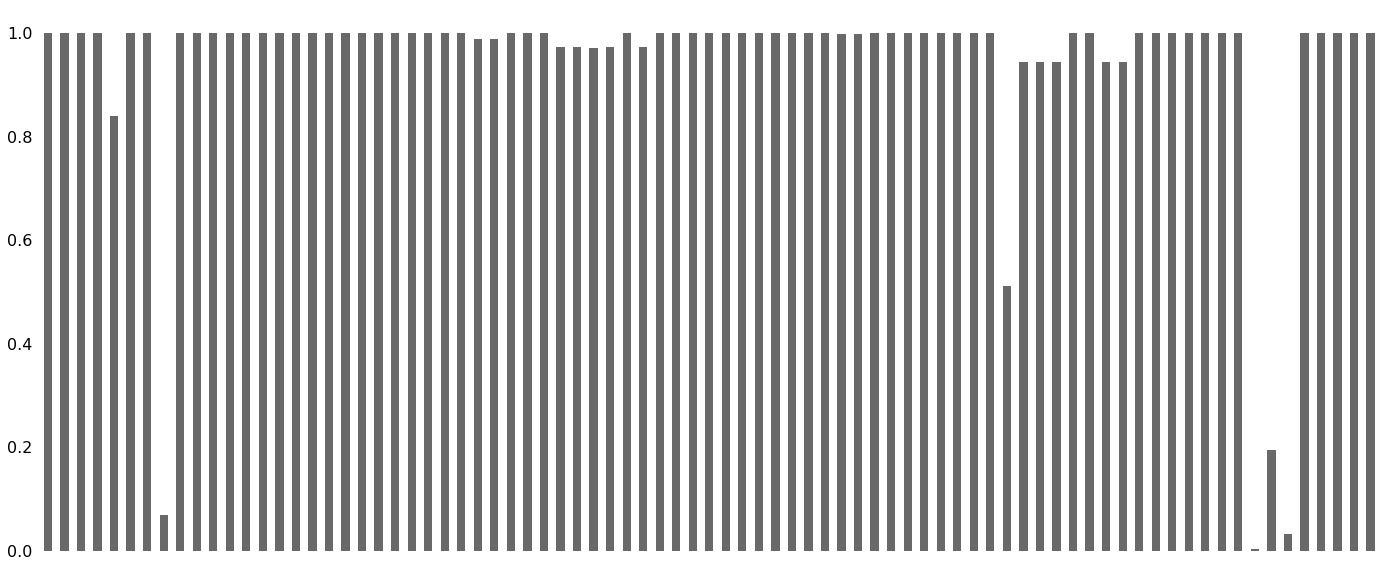

In [4]:
msno.bar(df)

In [5]:
# looks like we are missing a lot of data
# lets get a look at what that missing data is:

df.isnull().sum()

Id                    0
PID                   0
MS SubClass           0
MS Zoning             0
Lot Frontage        330
Lot Area              0
Street                0
Alley              1911
Lot Shape             0
Land Contour          0
Utilities             0
Lot Config            0
Land Slope            0
Neighborhood          0
Condition 1           0
Condition 2           0
Bldg Type             0
House Style           0
Overall Qual          0
Overall Cond          0
Year Built            0
Year Remod/Add        0
Roof Style            0
Roof Matl             0
Exterior 1st          0
Exterior 2nd          0
Mas Vnr Type         22
Mas Vnr Area         22
Exter Qual            0
Exter Cond            0
Foundation            0
Bsmt Qual            55
Bsmt Cond            55
Bsmt Exposure        58
BsmtFin Type 1       55
BsmtFin SF 1          1
BsmtFin Type 2       56
BsmtFin SF 2          1
Bsmt Unf SF           1
Total Bsmt SF         1
Heating               0
Heating QC      

In [6]:
df.columns[df.isnull().sum() > 0]

Index(['Lot Frontage', 'Alley', 'Mas Vnr Type', 'Mas Vnr Area', 'Bsmt Qual',
       'Bsmt Cond', 'Bsmt Exposure', 'BsmtFin Type 1', 'BsmtFin SF 1',
       'BsmtFin Type 2', 'BsmtFin SF 2', 'Bsmt Unf SF', 'Total Bsmt SF',
       'Bsmt Full Bath', 'Bsmt Half Bath', 'Fireplace Qu', 'Garage Type',
       'Garage Yr Blt', 'Garage Finish', 'Garage Cars', 'Garage Area',
       'Garage Qual', 'Garage Cond', 'Pool QC', 'Fence', 'Misc Feature'],
      dtype='object')

In [7]:
# lets describe the numeric data:
df.describe()

,Id,PID,MS SubClass,Lot Frontage,Lot Area,Overall Qual,Overall Cond,Year Built,Year Remod/Add,Mas Vnr Area,BsmtFin SF 1,BsmtFin SF 2,Bsmt Unf SF,Total Bsmt SF,1st Flr SF,2nd Flr SF,Low Qual Fin SF,Gr Liv Area,Bsmt Full Bath,Bsmt Half Bath,Full Bath,Half Bath,Bedroom AbvGr,Kitchen AbvGr,TotRms AbvGrd,Fireplaces,Garage Yr Blt,Garage Cars,Garage Area,Wood Deck SF,Open Porch SF,Enclosed Porch,3Ssn Porch,Screen Porch,Pool Area,Misc Val,Mo Sold,Yr Sold,SalePrice
count,2051.000000,2.051000e+03,2051.000000,1721.000000,2051.000000,2051.000000,2051.000000,2051.000000,2051.000000,2029.000000,2050.000000,2050.000000,2050.000000,2050.000000,2051.000000,2051.000000,2051.000000,2051.000000,2049.000000,2049.000000,2051.000000,2051.000000,2051.000000,2051.000000,2051.000000,2051.000000,1937.000000,2050.000000,2050.000000,2051.000000,2051.000000,2051.000000,2051.000000,2051.000000,2051.000000,2051.000000,2051.000000,2051.000000,2051.000000
mean,1474.033642,7.135900e+08,57.008776,69.055200,10065.208191,6.112140,5.562165,1971.708922,1984.190151,99.695909,442.300488,47.959024,567.728293,1057.987805,1164.488055,329.329108,5.512921,1499.330083,0.427526,0.063446,1.577279,0.371039,2.843491,1.042906,6.435885,0.590931,1978.707796,1.776585,473.671707,93.833740,47.556802,22.571916,2.591419,16.511458,2.397855,51.574354,6.219893,2007.775719,181469.701609
std,843.980841,1.886918e+08,42.824223,23.260653,6742.488909,1.426271,1.104497,30.177889,21.036250,174.963129,461.204124,165.000901,444.954786,449.410704,396.446923,425.671046,51.068870,500.447829,0.522673,0.251705,0.549279,0.501043,0.826618,0.209790,1.560225,0.638516,25.441094,0.764537,215.934561,128.549416,66.747241,59.845110,25.229615,57.374204,37.782570,573.393985,2.744736,1.312014,79258.659352
min,1.000000,5.263011e+08,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,0.000000,0.000000,0.000000,334.000000,0.000000,0.000000,334.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,1895.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,12789.000000
25%,753.500000,5.284581e+08,20.000000,58.000000,7500.000000,5.000000,5.000000,1953.500000,1964.500000,0.000000,0.000000,0.000000,220.000000,793.000000,879.500000,0.000000,0.000000,1129.000000,0.000000,0.000000,1.000000,0.000000,2.000000,1.000000,5.000000,0.000000,1961.000000,1.000000,319.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000,2007.000000,129825.000000
50%,1486.000000,5.354532e+08,50.000000,68.000000,9430.000000,6.000000,5.000000,1974.000000,1993.000000,0.000000,368.000000,0.000000,474.500000,994.500000,1093.000000,0.000000,0.000000,1444.000000,0.000000,0.000000,2.000000,0.000000,3.000000,1.000000,6.000000,1.000000,1980.000000,2.000000,480.000000,0.000000,27.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,162500.000000
75%,2198.000000,9.071801e+08,70.000000,80.000000,11513.500000,7.000000,6.000000,2001.000000,2004.000000,161.000000,733.750000,0.000000,811.000000,1318.750000,1405.000000,692.500000,0.000000,1728.500000,1.000000,0.000000,2.000000,1.000000,3.000000,1.000000,7.000000,1.000000,2002.000000,2.000000,576.000000,168.000000,70.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,2930.000000,9.241520e+08,190.000000,313.000000,159000.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,1474.000000,2336.000000,6110.000000,5095.000000,1862.000000,1064.000000,5642.000000,3.000000,2.000000,4.000000,2.000000,8.000000,3.000000,15.000000,4.000000,2207.000000,5.000000,1418.000000,1424.000000,547.000000,432.000000,508.000000,490.000000,800.000000,17000.000000,12.000000,2010.000000,611657.000000


In [8]:
# it's to be expected that there are going to be some low outliers, 
# and we are missing the column "Sale Condition" that would help us
# account for some of these. So lets just drop the 3 lowest priced homes
# in the dataset

low_drop = list(df.nsmallest(3, 'SalePrice').index)
df.drop(index=low_drop, inplace=True)
df.index = list(range(len(df)))
df.describe()

,Id,PID,MS SubClass,Lot Frontage,Lot Area,Overall Qual,Overall Cond,Year Built,Year Remod/Add,Mas Vnr Area,BsmtFin SF 1,BsmtFin SF 2,Bsmt Unf SF,Total Bsmt SF,1st Flr SF,2nd Flr SF,Low Qual Fin SF,Gr Liv Area,Bsmt Full Bath,Bsmt Half Bath,Full Bath,Half Bath,Bedroom AbvGr,Kitchen AbvGr,TotRms AbvGrd,Fireplaces,Garage Yr Blt,Garage Cars,Garage Area,Wood Deck SF,Open Porch SF,Enclosed Porch,3Ssn Porch,Screen Porch,Pool Area,Misc Val,Mo Sold,Yr Sold,SalePrice
count,2048.000000,2.048000e+03,2048.000000,1718.000000,2048.000000,2048.000000,2048.000000,2048.000000,2048.000000,2026.000000,2047.000000,2047.000000,2047.000000,2047.000000,2048.000000,2048.000000,2048.000000,2048.000000,2046.000000,2046.000000,2048.000000,2048.000000,2048.000000,2048.000000,2048.000000,2048.000000,1935.000000,2047.000000,2047.000000,2048.000000,2048.000000,2048.000000,2048.000000,2048.000000,2048.000000,2048.000000,2048.000000,2048.000000,2048.000000
mean,1474.990234,7.133097e+08,57.053223,69.054715,10064.269043,6.117676,5.564453,1971.767578,1984.229492,99.843534,442.706888,48.029311,568.119199,1058.855398,1165.078125,329.811523,5.520996,1500.410645,0.428152,0.063539,1.578125,0.371582,2.844727,1.042969,6.438965,0.591309,1978.747804,1.777235,473.746947,93.971191,47.371094,22.548828,2.595215,16.535645,2.401367,51.649902,6.219727,2007.773926,181705.844238
std,843.952256,1.886876e+08,42.839444,23.278427,6746.509455,1.419152,1.102356,30.155948,21.023681,175.050567,461.333264,165.111598,445.032606,448.989843,396.432443,425.795971,51.105842,500.012762,0.522800,0.251878,0.549237,0.501208,0.826592,0.209937,1.559184,0.638653,25.420832,0.764057,215.732444,128.593343,65.947337,59.849931,25.247901,57.412746,37.810135,573.810601,2.743124,1.311765,79074.916716
min,1.000000,5.263011e+08,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,0.000000,0.000000,0.000000,334.000000,0.000000,0.000000,334.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,1895.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,35000.000000
25%,754.750000,5.284581e+08,20.000000,58.000000,7500.000000,5.000000,5.000000,1954.000000,1965.000000,0.000000,0.000000,0.000000,220.000000,793.500000,880.000000,0.000000,0.000000,1131.750000,0.000000,0.000000,1.000000,0.000000,2.000000,1.000000,5.000000,0.000000,1961.000000,1.000000,319.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000,2007.000000,129900.000000
50%,1486.500000,5.354532e+08,50.000000,68.000000,9417.500000,6.000000,5.000000,1974.000000,1993.000000,0.000000,368.000000,0.000000,475.000000,996.000000,1093.000000,0.000000,0.000000,1445.500000,0.000000,0.000000,2.000000,0.000000,3.000000,1.000000,6.000000,1.000000,1980.000000,2.000000,480.000000,0.000000,27.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,162700.000000
75%,2199.250000,9.071801e+08,70.000000,80.000000,11512.750000,7.000000,6.000000,2001.000000,2004.000000,161.750000,734.000000,0.000000,811.000000,1319.000000,1405.000000,694.250000,0.000000,1729.250000,1.000000,0.000000,2.000000,1.000000,3.000000,1.000000,7.000000,1.000000,2002.000000,2.000000,576.000000,168.000000,70.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,2930.000000,9.241520e+08,190.000000,313.000000,159000.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,1474.000000,2336.000000,6110.000000,5095.000000,1862.000000,1064.000000,5642.000000,3.000000,2.000000,4.000000,2.000000,8.000000,3.000000,15.000000,4.000000,2207.000000,5.000000,1418.000000,1424.000000,547.000000,432.000000,508.000000,490.000000,800.000000,17000.000000,12.000000,2010.000000,611657.000000


In [9]:
# there is one record that is lacking numeric data for several features:
df[df['Total Bsmt SF'].isnull()]

,Id,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,Utilities,Lot Config,Land Slope,Neighborhood,Condition 1,Condition 2,Bldg Type,House Style,Overall Qual,Overall Cond,Year Built,Year Remod/Add,Roof Style,Roof Matl,Exterior 1st,Exterior 2nd,Mas Vnr Type,Mas Vnr Area,Exter Qual,Exter Cond,Foundation,Bsmt Qual,Bsmt Cond,Bsmt Exposure,BsmtFin Type 1,BsmtFin SF 1,BsmtFin Type 2,BsmtFin SF 2,Bsmt Unf SF,Total Bsmt SF,Heating,Heating QC,Central Air,Electrical,1st Flr SF,2nd Flr SF,Low Qual Fin SF,Gr Liv Area,Bsmt Full Bath,Bsmt Half Bath,Full Bath,Half Bath,Bedroom AbvGr,Kitchen AbvGr,Kitchen Qual,TotRms AbvGrd,Functional,Fireplaces,Fireplace Qu,Garage Type,Garage Yr Blt,Garage Finish,Garage Cars,Garage Area,Garage Qual,Garage Cond,Paved Drive,Wood Deck SF,Open Porch SF,Enclosed Porch,3Ssn Porch,Screen Porch,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,SalePrice
1325,1342,903230120,20,RM,99.0,5940,Pave,NaN,IR1,Lvl,AllPub,FR3,Gtl,BrkSide,Feedr,Norm,1Fam,1Story,4,7,1946,1950,Gable,CompShg,MetalSd,CBlock,None,0.0,TA,TA,PConc,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,GasA,TA,Y,FuseA,896,0,0,896,NaN,NaN,1,0,2,1,TA,4,Typ,0,NaN,Detchd,1946.0,Unf,1.0,280.0,TA,TA,Y,0,0,0,0,0,0,NaN,MnPrv,NaN,0,4,2008,ConLD,79000


In [10]:
# lets just get rid of it:
df.drop(index=1325, inplace=True)

In [11]:
# there's one lacking data for Garage Area:
df[df['Garage Area'].isnull()]

,Id,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,Utilities,Lot Config,Land Slope,Neighborhood,Condition 1,Condition 2,Bldg Type,House Style,Overall Qual,Overall Cond,Year Built,Year Remod/Add,Roof Style,Roof Matl,Exterior 1st,Exterior 2nd,Mas Vnr Type,Mas Vnr Area,Exter Qual,Exter Cond,Foundation,Bsmt Qual,Bsmt Cond,Bsmt Exposure,BsmtFin Type 1,BsmtFin SF 1,BsmtFin Type 2,BsmtFin SF 2,Bsmt Unf SF,Total Bsmt SF,Heating,Heating QC,Central Air,Electrical,1st Flr SF,2nd Flr SF,Low Qual Fin SF,Gr Liv Area,Bsmt Full Bath,Bsmt Half Bath,Full Bath,Half Bath,Bedroom AbvGr,Kitchen AbvGr,Kitchen Qual,TotRms AbvGrd,Functional,Fireplaces,Fireplace Qu,Garage Type,Garage Yr Blt,Garage Finish,Garage Cars,Garage Area,Garage Qual,Garage Cond,Paved Drive,Wood Deck SF,Open Porch SF,Enclosed Porch,3Ssn Porch,Screen Porch,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,SalePrice
1709,2237,910201180,70,RM,50.0,9060,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,IDOTRR,Norm,Norm,1Fam,2Story,5,6,1923,1999,Gable,CompShg,Wd Sdng,Plywood,None,0.0,TA,TA,BrkTil,Gd,TA,No,ALQ,548.0,Unf,0.0,311.0,859.0,GasA,Ex,Y,SBrkr,942,886,0,1828,0.0,0.0,2,0,3,1,Gd,6,Typ,0,NaN,Detchd,NaN,NaN,NaN,NaN,NaN,NaN,Y,174,0,212,0,0,0,NaN,MnPrv,NaN,0,3,2007,WD,150909


In [12]:
# it claims there is a garage, but there is no other data for it. Let's just drop this one too
df.drop(index=1709, inplace=True)

In [13]:
# now we should re-index:
df.index = list(range(len(df)))

In [14]:
# lets impute bsmt fin sf 1 NaNs with mean values 
df = df.replace({'BsmtFin SF 1' : np.nan}, df['BsmtFin SF 1'].mean())

In [15]:
# do the same for ms vnr area
df = df.replace({'Mas Vnr Area' : np.nan}, df['Mas Vnr Area'].mean())


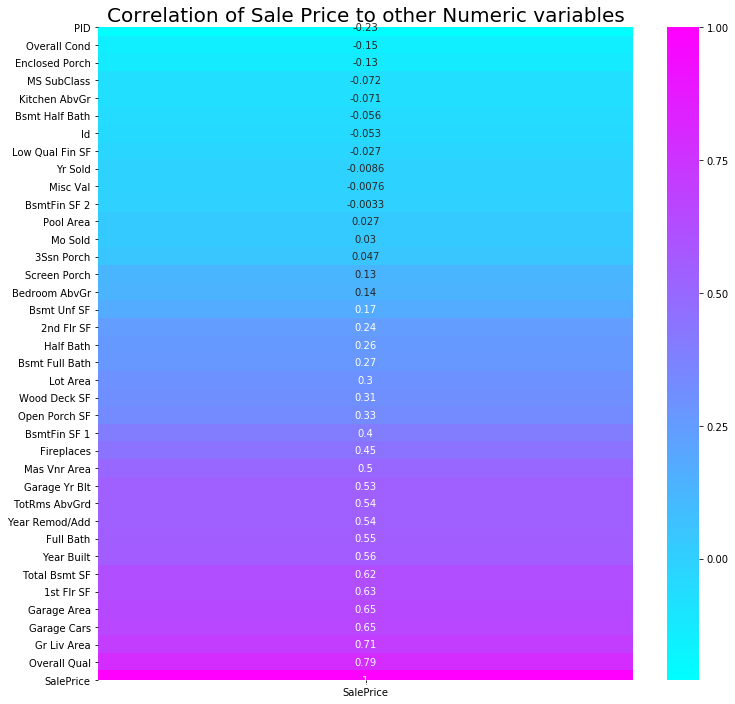

In [16]:
# Time to do a correlation heatmap!

big_na_cols = ['Lot Frontage', 'Alley', 'Fireplace Qu', 'Pool QC', 'Fence', 'Misc Feature']
df_corr = df.drop(columns=(big_na_cols))
df_corr.dropna(axis=0, inplace=True)

plt.figure(figsize = (12, 12))
plt.title('Correlation of Sale Price to other Numeric variables', fontsize=20)
sns.heatmap(df_corr.corr()[['SalePrice']].sort_values('SalePrice'), annot=True, cmap='cool')

In [17]:
dummy_cols = ['Overall Qual', 
              'Garage Cars', 
              'Year Built', 
              'Full Bath', 
              'Year Remod/Add', 
              'TotRms AbvGrd', 
              'Garage Yr Blt',
              'Fireplaces', 
              'Bsmt Full Bath',
              'Half Bath',
              'Neighborhood',
              'Exter Qual']

contin_cols = [
    'Gr Liv Area',
    'Garage Area',
    '1st Flr SF',
    'Mas Vnr Area',
    'BsmtFin SF 1',
    'Open Porch SF',
    'Wood Deck SF',
    'Lot Area',
]

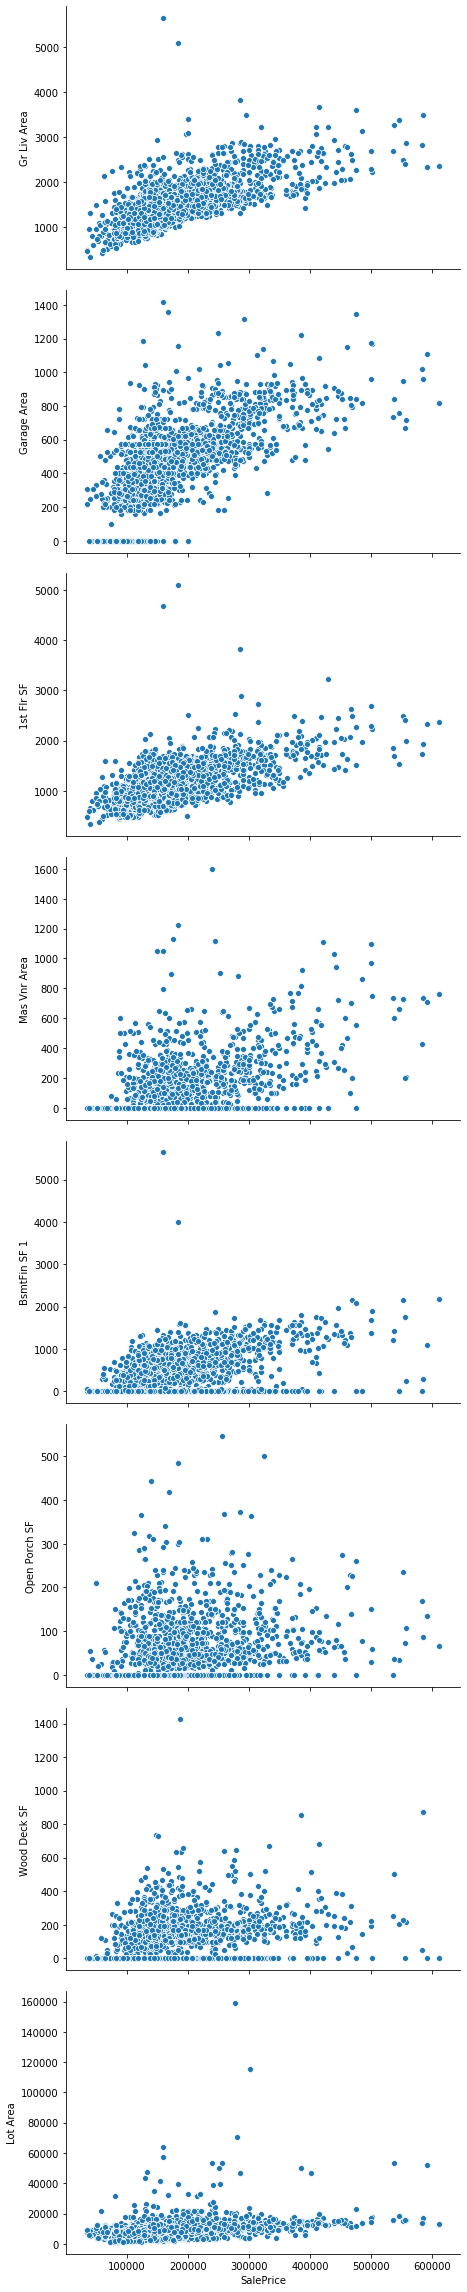

In [18]:
# Lets take a look at the relationship between our continuous features and price

sns.pairplot(df, x_vars='SalePrice', y_vars=contin_cols, height=4, aspect=1.6);

In [126]:
sns.barplot(df, x_vars='SalePrice', y_vars=dummy_cols, height=4, aspect=1.6);

TypeError: unsupported operand type(s) for +: 'float' and 'str'

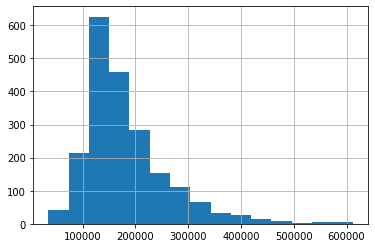

In [124]:
df['SalePrice'].hist(bins=15)

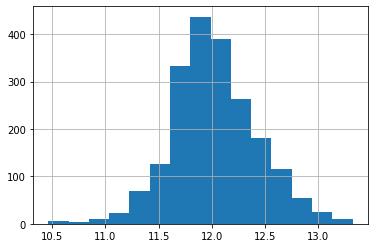

In [125]:
np.log(df['SalePrice']).hist(bins=15)

A ln transform on y will probably be called for

We can probably go ahead and submit our first Kaggle CSV using just this data for the model. 

We'll keep the dummy_cols for later use when making dummies.

### EDA findings: 

Most of the null values are categorical that are associated with other features, eg Bsmt Qual is probably only populated when a house actually has a basement. This will be further confirmed as we dig more into feature selection.

Fortunately, it looks like most of the columns that are missing values are categorical in nature. This means that if we choose to use them as dummys, the NaNs will be ignored. We'll dig a little deeper on some of the others like Lot Frontage later. It may be the case that lot frontage is a NaN for categories like appartments and condos, in which case we can impute a proxy like the mean for all of those since the difference can be accounted for in another variable. Another option is imputing them with 0's and using an engineered feature like Lot Frontage * SubClassDummy.

## 4. Initial Modeling

We'll start with a model that only incorporates the numerical features that we have selected above and submit to Kaggle to see how we do relative to the rest of the cohorts. Because this data set has so many features, we'll do our subsequent EDA a little more piecemeal as we refine the model.

In [21]:
# we need to get everything into the right format for Kaggle, 
# which is a csv that only has the ID and predicted values

kaggle_test = pd.read_csv('./datasets/test.csv')
kaggle_test.head()

,Id,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,Utilities,Lot Config,Land Slope,Neighborhood,Condition 1,Condition 2,Bldg Type,House Style,Overall Qual,Overall Cond,Year Built,Year Remod/Add,Roof Style,Roof Matl,Exterior 1st,Exterior 2nd,Mas Vnr Type,Mas Vnr Area,Exter Qual,Exter Cond,Foundation,Bsmt Qual,Bsmt Cond,Bsmt Exposure,BsmtFin Type 1,BsmtFin SF 1,BsmtFin Type 2,BsmtFin SF 2,Bsmt Unf SF,Total Bsmt SF,Heating,Heating QC,Central Air,Electrical,1st Flr SF,2nd Flr SF,Low Qual Fin SF,Gr Liv Area,Bsmt Full Bath,Bsmt Half Bath,Full Bath,Half Bath,Bedroom AbvGr,Kitchen AbvGr,Kitchen Qual,TotRms AbvGrd,Functional,Fireplaces,Fireplace Qu,Garage Type,Garage Yr Blt,Garage Finish,Garage Cars,Garage Area,Garage Qual,Garage Cond,Paved Drive,Wood Deck SF,Open Porch SF,Enclosed Porch,3Ssn Porch,Screen Porch,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type
0,2658,902301120,190,RM,69.0,9142,Pave,Grvl,Reg,Lvl,AllPub,Inside,Gtl,OldTown,Norm,Norm,2fmCon,2Story,6,8,1910,1950,Gable,CompShg,AsbShng,AsbShng,None,0.0,TA,Fa,Stone,Fa,TA,No,Unf,0,Unf,0,1020,1020,GasA,Gd,N,FuseP,908,1020,0,1928,0,0,2,0,4,2,Fa,9,Typ,0,NaN,Detchd,1910.0,Unf,1,440,Po,Po,Y,0,60,112,0,0,0,NaN,NaN,NaN,0,4,2006,WD
1,2718,905108090,90,RL,NaN,9662,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Sawyer,Norm,Norm,Duplex,1Story,5,4,1977,1977,Gable,CompShg,Plywood,Plywood,None,0.0,TA,TA,CBlock,Gd,TA,No,Unf,0,Unf,0,1967,1967,GasA,TA,Y,SBrkr,1967,0,0,1967,0,0,2,0,6,2,TA,10,Typ,0,NaN,Attchd,1977.0,Fin,2,580,TA,TA,Y,170,0,0,0,0,0,NaN,NaN,NaN,0,8,2006,WD
2,2414,528218130,60,RL,58.0,17104,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,7,5,2006,2006,Gable,CompShg,VinylSd,VinylSd,None,0.0,Gd,TA,PConc,Gd,Gd,Av,GLQ,554,Unf,0,100,654,GasA,Ex,Y,SBrkr,664,832,0,1496,1,0,2,1,3,1,Gd,7,Typ,1,Gd,Attchd,2006.0,RFn,2,426,TA,TA,Y,100,24,0,0,0,0,NaN,NaN,NaN,0,9,2006,New
3,1989,902207150,30,RM,60.0,8520,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,OldTown,Norm,Norm,1Fam,1Story,5,6,1923,2006,Gable,CompShg,Wd Sdng,Wd Sdng,None,0.0,Gd,TA,CBlock,TA,TA,No,Unf,0,Unf,0,968,968,GasA,TA,Y,SBrkr,968,0,0,968,0,0,1,0,2,1,TA,5,Typ,0,NaN,Detchd,1935.0,Unf,2,480,Fa,TA,N,0,0,184,0,0,0,NaN,NaN,NaN,0,7,2007,WD
4,625,535105100,20,RL,NaN,9500,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,1Fam,1Story,6,5,1963,1963,Gable,CompShg,Plywood,Plywood,BrkFace,247.0,TA,TA,CBlock,Gd,TA,No,BLQ,609,Unf,0,785,1394,GasA,Gd,Y,SBrkr,1394,0,0,1394,1,0,1,1,3,1,TA,6,Typ,2,Gd,Attchd,1963.0,RFn,2,514,TA,TA,Y,0,76,0,0,185,0,NaN,NaN,NaN,0,7,2009,WD


In [22]:
kaggle_test["Gr Liv Area"].sort_values(ascending=False)

170    4476
463    4316
115    3627
273    3447
484    3194
       ... 
542     630
231     630
482     630
529     599
514     407
Name: Gr Liv Area, Length: 878, dtype: int64

In [23]:
kaggle_test[contin_cols].isnull().sum()

Gr Liv Area      0
Garage Area      0
1st Flr SF       0
Mas Vnr Area     1
BsmtFin SF 1     0
Open Porch SF    0
Wood Deck SF     0
Lot Area         0
dtype: int64

In [24]:
kaggle_test = kaggle_test.replace({'BsmtFin SF 1' : np.nan}, df['BsmtFin SF 1'].mean())
kaggle_test = kaggle_test.replace({'Mas Vnr Area' : np.nan}, df['Mas Vnr Area'].mean())

In [25]:
submission = kaggle_test[['Id']].copy()
submission.head()

,Id
0,2658
1,2718
2,2414
3,1989
4,625


In [26]:
test_features = contin_cols
X_kag_test = kaggle_test[test_features]
X_kag_test.head()
X_train = df[test_features]
y_train = df['SalePrice']

In [27]:
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [28]:
submission['SalePrice'] = lr.predict(X_kag_test)
submission.head()

,Id,SalePrice
0,2658,176536.425228
1,2718,224617.818495
2,2414,155760.191097
3,1989,122790.627179
4,625,197155.967729


In [29]:
submission.to_csv('./submissions/submission_0.csv', index=False)

## 5. Model Refinement

### Automation

Lets start by automating some of the more repetive code that may come up. 

In [30]:
def fit_linear_reg(X, y):
    '''Fit a linear regression model to an already defined X and y
    
    Keyword Arguments:
    X -- the feature matrix 
    y -- the target values of the feature matrix
    
    Returns:
    model -- a linear regression model fit to X and y
    predicts -- the predictions of y based on X
    resids -- the y residuals'''
     
    model = LinearRegression()
    model.fit(X, y)
    predicts = model.predict(X)
    resids = y - predicts
    
    return model, predicts, resids

In [31]:
# Let's plot resids as a function as well:

def plot_resids(y, predictions, residuals, title):
    """Plots residuals vs Observations. Requires Seaborn as sns
    
    Keyword arguments:
    y - the dependent variable training data/observed data
    predictions -- The output of a model
    residuals -- The matched residuals of the above output
    
    Returns:
    Two scatterplots: predictions vs actual values and residual vs actual values
    """
    
    fig, (ax1, ax2) = plt.subplots(figsize = (14, 6), ncols=2)
    plt.subplots_adjust(wspace = 0.25)
    fig.suptitle(title, fontsize=18)
    
    sns.scatterplot(predictions, y, ax=ax1)
    ax1.set_title("Predictions vs. Actual")
    ax1.set_ylabel("Actual")
    ax1.set_xlabel("Predicted")

    sns.scatterplot(y, residuals, ax=ax2)
    ax2.set_title('Residuals vs Observations')
    ax2.set_ylabel("Residual")
    ax2.set_xlabel("Observation")
    

In [32]:
# How about doing this for metrics too?

def print_lr_metrics(lr, X, y):
    """Prints MAE, MSE, SSE, RSE, R2, R2_adj, and K-fold cross val score for k=5
    
    Keyword Arguments:
    lr -- the model used to generate the predictions
    X -- independent matrix used to generate the predictions
    y -- the observed dependent variable associated with X
    predictions -- the predictions associated with X
    
            
    Returns:
    printed output of the previously mentioned metrics
    """
    predictions = lr.predict(X)
    residuals = y - predictions
    sum_sq_err = (residuals ** 2).sum()
    mae = metrics.mean_absolute_error(y, predictions)
    mse = metrics.mean_squared_error(y, predictions)
    r_2 = lr.score(X, y)
    n, k = X.shape
    r2_adj = 1 - (((1 - r_2) * (n-1)) / (n-k-1))
    cv_score = cross_val_score(lr, X, y, cv=10).mean()
    print('The mean of residuals is: ', residuals.mean())
    print('The Mean Absolute Error: ', mae)
    print('The Sum Squared Error: ', sum_sq_err)
    print('The Mean Squared Error: ', mse)
    print('The Root Mean Squared Error: ', np.sqrt(mse))
    print('The Coefficient of Determination: ', r_2)
    print('The Adjusted Coefficient of Determination: ', r2_adj)
    print('The 10-fold cross validation score: ', cv_score)
    


In [33]:
def model_score_compare(model, X_train, y_train, X_test, y_test):
    '''Compare the scores of training data and testing data
    
    Keyword Arguments:
    model -- the fitted model
    X_train -- X training matrix
    y_train -- y training series
    X_test -- X testing matrix
    y_test -- y testing series
    
    Returns:
    train_score -- the model training score
    test_score -- the model testing score'''
    
    train_score = model.score(X_train, y_train)
    test_score = model.score(X_test, y_test)
    return train_score, test_score

In [34]:
# finally, lets make a function that automatically creates 
# a Kaggle submission CSV

# instantiate a counter

kag_counter = 1

def create_kaggle_csv(model, X_test_data, counter, test_data=kaggle_test, y_index=['Id'], y_name='SalePrice', log=True ):
    """Creates a Kaggle file for submission with suffix kag_counter
    
    Keyword Arguments:
    model -- the fitted model that will be used to make predictions
    X_test_data -- the dataframe for the test dataset used to make predicitons
    test_data -- the data frame from which the test data was taken
    y_index -- the column of the test data used to index the predictions
    y_name -- the column name in the target CSV for the predictions 
                    NOTE: X_test_data **MUST** be in the same format as the model!!
                    Make sure that any transforms and/or scaling is done first!!
                    
    Returns:
    A CSV file with the index and predicted values
    A statement that lets you know the ordinal of this submission"""
    
    output_name = "submission_" + str(counter) +'.csv'
    submission = test_data[y_index].copy()
    submission[y_name] = model.predict(X_test_data)
    if log == True:
        submission[y_name] = np.exp(submission[y_name])
    submission.to_csv('./submissions/' + output_name, index=False)
    print("This is submission number: ", counter)
    counter += 1
    return counter

### Basic Feature Generation

Our dependent feature is 'SalePrice', although given the distribution, it may be more beneficial to use the ln of this feature.

Now that we're getting into more robust modelling, we need to split the data into training and testing sets. Then we'll start refining the model by doing a polynomial expansion of our numerical features, then determining which of them are important via regularization with Lasso.

In [35]:
# now that we have some functions built, let's play around with some features!
y_targ = 'SalePrice'

# going back to the original dataframe, there are a few columns I want to dummy.
# before we get that far though, we should train/test/split our data and
# try a poly fit for our numeric data. 

X_targ = df[contin_cols]
y = df[y_targ]

X_train, X_test, y_train, y_test = train_test_split(X_targ, y, test_size = 0.2, random_state = r_state)

In [36]:
poly = PolynomialFeatures()

X_train_pf = poly.fit_transform(X_train)
X_test_pf = poly.transform(X_test)

X_train_pf = pd.DataFrame(X_train_pf, columns=poly.get_feature_names(X_targ.columns))
X_test_pf = pd.DataFrame(X_test_pf, columns=poly.get_feature_names(X_targ.columns))

In [37]:
lr_poly, poly_preds, poly_resids = fit_linear_reg(X_train_pf, y_train)

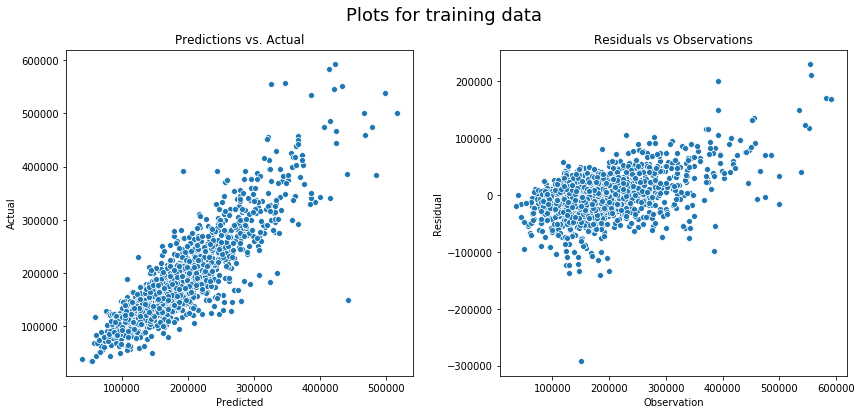

In [38]:
plot_resids(y_train, poly_preds, poly_resids, "Plots for training data")

In [39]:
# we definitely have a kind of shotgun spread to the residuals. 
# a log conversion might be in order here.

print_lr_metrics(lr_poly, X_train_pf, y_train)

The mean of residuals is:  -6.333107361000733e-12
The Mean Absolute Error:  25814.171573985182
The Sum Squared Error:  2183096732716.1208
The Mean Squared Error:  1334411205.8166997
The Root Mean Squared Error:  36529.593562161346
The Coefficient of Determination:  0.7823655371037018
The Adjusted Coefficient of Determination:  0.7762060711726745
The 10-fold cross validation score:  0.4829712336094773


In [40]:
# thats a very odd cross val score, so lets confirm
cross_val_score(lr_poly, X_train_pf, y_train, cv=5)

array([ 0.71927803,  0.80562473, -0.6537855 ,  0.59231814,  0.7692684 ])

In [41]:
# I suspect we have an outlier. . . 

In [42]:
model_score_compare(lr_poly, X_train_pf, y_train, X_test_pf, y_test)

(0.7823655371037018, 0.7432383719479368)

In [43]:
# in it's current state, the model seems to be pretty overfit to the data
# lets try the log conversion first to see how that affects residuals:

y_train_ln = np.log(y_train)
y_test_ln = np.log(y_test)

lr_poly_ln, poly_preds_ln, resids_poly_ln = fit_linear_reg(X_train_pf, y_train_ln)

In [44]:
model_score_compare(lr_poly_ln, X_train_pf, y_train_ln, X_test_pf, y_test_ln)

(0.7773988559093897, 0.7822209973144783)

In [45]:
print_lr_metrics(lr_poly_ln, X_train_pf, y_train_ln)

The mean of residuals is:  1.0792779329852378e-15
The Mean Absolute Error:  0.14071957516772646
The Sum Squared Error:  57.85424471180203
The Mean Squared Error:  0.03536323026393767
The Root Mean Squared Error:  0.18805113736411613
The Coefficient of Determination:  0.7773988559093897
The Adjusted Coefficient of Determination:  0.7710988235294668
The 10-fold cross validation score:  0.6771677347915646


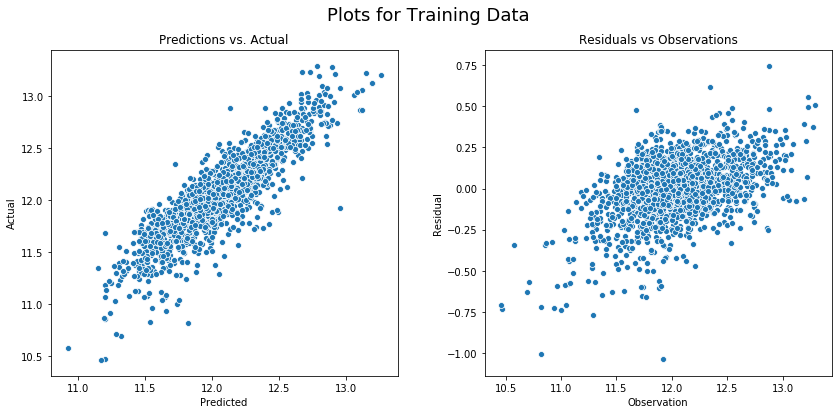

In [46]:
plot_resids(y_train_ln, poly_preds_ln, resids_poly_ln, "Plots for Training Data")

In [47]:
# Let's scale everything then use a LassoCV to narrow down some of these variables!

ss = StandardScaler()
Z_train = ss.fit_transform(X_train_pf)
Z_test = ss.transform(X_test_pf);

In [48]:
# since we have no idea whatsoever what the alpha should be, lets just iterate through a big 
# space. 

lasso_alphas = np.logspace(-4, -2, 1_000)
lasso = LassoCV(alphas=lasso_alphas, cv=5, max_iter=5_000)

lasso.fit(Z_train, y_train_ln);

In [49]:
bench_train_score = lasso.score(Z_train, y_train_ln)
bench_train_score

0.7692452517893301

In [50]:
bench_test_score = lasso.score(Z_test, y_test_ln)
bench_test_score

0.7691773443688629

In [51]:
lasso.alpha_

0.0011887076977119032

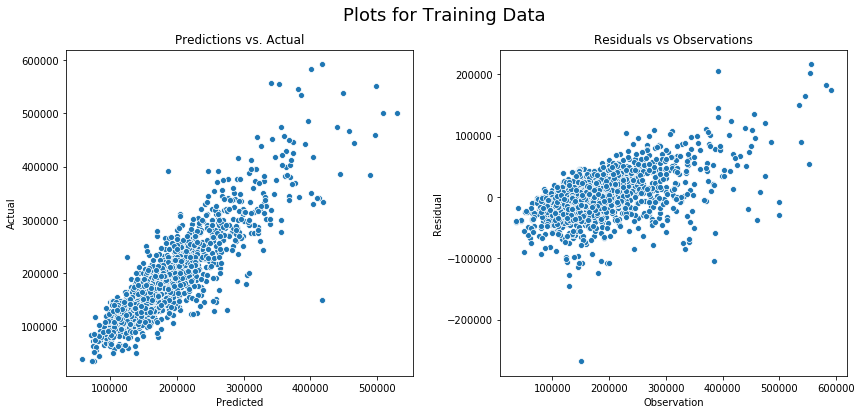

In [52]:
# definitely a major improvement! We've only sacrificed a small amount of 
# bias for a pretty big leap in the improvement of the variance
# lets take a look at the plots

preds = np.exp(lasso.predict(Z_train))
resids = np.exp(y_train_ln) - preds
plot_resids(y_train, preds, resids, 'Plots for Training Data')

Now that we have a better aggreement between our training set and testing set, lets go ahead and predict values for the test.csv and submit to Kaggle to see how we're doing! First, we need to do the same polynomial transform on the Kaggle test set:

In [53]:
# first, let's make sure that our kaggle test data has the same number of columns as our train data.
X_train.shape

(1636, 8)

In [54]:
X_kag_test.shape

(878, 8)

In [55]:
# now we can poly transform the kaggle test data 
X_kag_test_pf = poly.transform(X_kag_test)
X_kag_test_pf.shape

(878, 45)

In [56]:
Z_train.shape

(1636, 45)

In [57]:
# now we need to scale the kaggle test data:
Z_test_kag = ss.transform(X_kag_test_pf)

In [58]:
# now we can generate our predictions and CSV:
kag_counter = 1
kag_counter = create_kaggle_csv(lasso, Z_test_kag, kag_counter)

This is submission number:  1


In [59]:
kag_counter

2

In [60]:
# This submission was a definite improvement over the previous!
# Now let's take a look at the variables that the model discarded and only keep those for future modeling:

lasso_betas = pd.Series(index = poly.get_feature_names(X_train.columns), data = lasso.coef_)
lasso_betas[lasso_betas != 0]

Gr Liv Area                   0.288955
Garage Area                   0.132129
1st Flr SF                    0.107279
Mas Vnr Area                  0.006926
BsmtFin SF 1                  0.095796
Open Porch SF                 0.059321
Wood Deck SF                  0.052559
Lot Area                      0.032248
Gr Liv Area^2                -0.090188
Gr Liv Area Garage Area       0.035006
Gr Liv Area 1st Flr SF       -0.123783
Gr Liv Area BsmtFin SF 1     -0.004593
Gr Liv Area Wood Deck SF     -0.010753
Garage Area^2                -0.066128
Garage Area 1st Flr SF        0.000361
Garage Area Mas Vnr Area      0.079139
Garage Area BsmtFin SF 1     -0.013571
Garage Area Open Porch SF     0.058927
Garage Area Lot Area         -0.035458
1st Flr SF Open Porch SF      0.040419
1st Flr SF Wood Deck SF       0.047099
1st Flr SF Lot Area          -0.004613
Mas Vnr Area^2               -0.031410
Mas Vnr Area BsmtFin SF 1    -0.007871
Mas Vnr Area Open Porch SF   -0.037070
Mas Vnr Area Lot Area    

In [61]:
lasso_beta_abs = abs(lasso_betas)

In [62]:
lasso_beta_abs[lasso_beta_abs > 0].sort_values(ascending=False)

Gr Liv Area                   0.288955
Garage Area                   0.132129
Gr Liv Area 1st Flr SF        0.123783
1st Flr SF                    0.107279
BsmtFin SF 1                  0.095796
Gr Liv Area^2                 0.090188
Garage Area Mas Vnr Area      0.079139
Open Porch SF^2               0.075884
Garage Area^2                 0.066128
Open Porch SF                 0.059321
Garage Area Open Porch SF     0.058927
Wood Deck SF                  0.052559
1st Flr SF Wood Deck SF       0.047099
1st Flr SF Open Porch SF      0.040419
Mas Vnr Area Open Porch SF    0.037070
Garage Area Lot Area          0.035458
Gr Liv Area Garage Area       0.035006
Lot Area                      0.032248
Wood Deck SF^2                0.031736
Mas Vnr Area^2                0.031410
BsmtFin SF 1 Wood Deck SF     0.026791
Open Porch SF Wood Deck SF    0.023838
Open Porch SF Lot Area        0.018823
Mas Vnr Area Lot Area         0.014423
Garage Area BsmtFin SF 1      0.013571
Gr Liv Area Wood Deck SF 

In [63]:
poly_feature_list = list(lasso_betas[lasso_beta_abs > 0.01].index)

In [64]:
# Now we have some features narrowed down. Time to add some dummies!

### Feature Generation Continued

We now have a lot of features from the polynomial model that have been retained for future model development.

The next step will be to explore dummy features that contribute to the model. 

We'll define a function that allows us to loop through all the relevant features and compare them to our nominal scores. Festures that improve both testing scores and training scores will be retained in a list, which will then be used in a function to populate our X and get the scores and model for the dummies that were retained.

Before we do any of that though, we need to get our Kaggle test data and training data aligned for the feature generation. First, we need to do the poly transform, and select the features that we chose from our lasso regression. Then, we need to concatenate the kaggle test data to the training data so that when we generate dummies, we don't miss any columns. Finally, after dummy generation, we need to separate the kaggle test data from the training data.

In [65]:
# first we need to do the poly transform

df_poly = df[contin_cols]
df_poly = poly.transform(df_poly)
df_poly = pd.DataFrame(df_poly, columns=(poly.get_feature_names(X_train.columns)))
df_poly.head()

,1,Gr Liv Area,Garage Area,1st Flr SF,Mas Vnr Area,BsmtFin SF 1,Open Porch SF,Wood Deck SF,Lot Area,Gr Liv Area^2,Gr Liv Area Garage Area,Gr Liv Area 1st Flr SF,Gr Liv Area Mas Vnr Area,Gr Liv Area BsmtFin SF 1,Gr Liv Area Open Porch SF,Gr Liv Area Wood Deck SF,Gr Liv Area Lot Area,Garage Area^2,Garage Area 1st Flr SF,Garage Area Mas Vnr Area,Garage Area BsmtFin SF 1,Garage Area Open Porch SF,Garage Area Wood Deck SF,Garage Area Lot Area,1st Flr SF^2,1st Flr SF Mas Vnr Area,1st Flr SF BsmtFin SF 1,1st Flr SF Open Porch SF,1st Flr SF Wood Deck SF,1st Flr SF Lot Area,Mas Vnr Area^2,Mas Vnr Area BsmtFin SF 1,Mas Vnr Area Open Porch SF,Mas Vnr Area Wood Deck SF,Mas Vnr Area Lot Area,BsmtFin SF 1^2,BsmtFin SF 1 Open Porch SF,BsmtFin SF 1 Wood Deck SF,BsmtFin SF 1 Lot Area,Open Porch SF^2,Open Porch SF Wood Deck SF,Open Porch SF Lot Area,Wood Deck SF^2,Wood Deck SF Lot Area,Lot Area^2
0,1.0,1479.0,475.0,725.0,289.0,533.0,44.0,0.0,13517.0,2187441.0,702525.0,1072275.0,427431.0,788307.0,65076.0,0.0,19991643.0,225625.0,344375.0,137275.0,253175.0,20900.0,0.0,6420575.0,525625.0,209525.0,386425.0,31900.0,0.0,9799825.0,83521.0,154037.0,12716.0,0.0,3906413.0,284089.0,23452.0,0.0,7204561.0,1936.0,0.0,594748.0,0.0,0.0,182709289.0
1,1.0,2122.0,559.0,913.0,132.0,637.0,74.0,0.0,11492.0,4502884.0,1186198.0,1937386.0,280104.0,1351714.0,157028.0,0.0,24386024.0,312481.0,510367.0,73788.0,356083.0,41366.0,0.0,6424028.0,833569.0,120516.0,581581.0,67562.0,0.0,10492196.0,17424.0,84084.0,9768.0,0.0,1516944.0,405769.0,47138.0,0.0,7320404.0,5476.0,0.0,850408.0,0.0,0.0,132066064.0
2,1.0,1057.0,246.0,1057.0,0.0,731.0,52.0,0.0,7922.0,1117249.0,260022.0,1117249.0,0.0,772667.0,54964.0,0.0,8373554.0,60516.0,260022.0,0.0,179826.0,12792.0,0.0,1948812.0,1117249.0,0.0,772667.0,54964.0,0.0,8373554.0,0.0,0.0,0.0,0.0,0.0,534361.0,38012.0,0.0,5790982.0,2704.0,0.0,411944.0,0.0,0.0,62758084.0
3,1.0,1444.0,400.0,744.0,0.0,0.0,0.0,100.0,9802.0,2085136.0,577600.0,1074336.0,0.0,0.0,0.0,144400.0,14154088.0,160000.0,297600.0,0.0,0.0,0.0,40000.0,3920800.0,553536.0,0.0,0.0,0.0,74400.0,7292688.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10000.0,980200.0,96079204.0
4,1.0,1445.0,484.0,831.0,0.0,0.0,59.0,0.0,14235.0,2088025.0,699380.0,1200795.0,0.0,0.0,85255.0,0.0,20569575.0,234256.0,402204.0,0.0,0.0,28556.0,0.0,6889740.0,690561.0,0.0,0.0,49029.0,0.0,11829285.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3481.0,0.0,839865.0,0.0,0.0,202635225.0


In [66]:
# now we create a dataframe with just the features we saved

X_refined = df_poly[poly_feature_list]
X_refined.index = list(range(len(X_refined)))
X_refined.shape

(2046, 26)

In [67]:
# while we're at it, lets do the same for the Kaggle test data:

X_kag_poly = poly.transform(X_kag_test)
X_kag_poly = pd.DataFrame(X_kag_poly, columns=(poly.get_feature_names(X_train.columns)))
X_kag_ref = X_kag_poly[poly_feature_list]
X_kag_ref.shape

(878, 26)

In [68]:
# now lets get the dummies. we'll concatenate the kaggle test set, then seperate
# so that we can make sure there are the same number of dummy columns. Code inspired by:
# https://stackoverflow.com/questions/41335718/keep-same-dummy-variable-in-training-and-testing-data

# first, we need to concatenate the original kaggle test data to the original dataframe:

data_df = df.drop(columns='SalePrice')
kaggle_df = kaggle_test
data_all = pd.concat([data_df, kaggle_df], axis=0, ignore_index=True)
data_all.shape

(2924, 80)

In [69]:
# now we get the number of items in our test set with refined features:
X_ref_rows = len(X_refined)

In [70]:
# now we can concatenate the refined training data to the refined kaggle test data:
data_ref = pd.concat([X_refined, X_kag_ref], axis=0, ignore_index=True)
data_ref.shape

(2924, 26)

In [71]:
# get the dummies from the training/kaggle dataset made above. We'll use 'Sale Type' as a model.
data_dummy = pd.get_dummies(data_all['TotRms AbvGrd'], drop_first=True)
data_dummy.shape

(2924, 13)

In [72]:
# concat the data and the dummies:
data_w_dum = pd.concat([data_ref, data_dummy], axis=1, ignore_index=True)

In [73]:
# now seperate back into seperate training and kaggle test sets:
X_ref_dum = data_w_dum[:X_ref_rows]
X_kag_dum = data_w_dum[X_ref_rows:]

In [74]:
# before we go any further, let's automate this bit:

def add_dummies(dummy, X_data, all_data=data_all, rows=X_ref_rows):
    '''This function will return a training dataset and a test dataset with 'dummy' one-hot encoded from all_data
    
    Keyword Arguments:
    dummy -- the column or list of columns to be One Hot Encoded
    X_data -- the combined train/test dataset with desired X features
    all_data -- the combined original dataset
    row -- the row number at which to split the dataset
    
    Returns:
    train_ref -- the training portion of the dataset with the new dummy encoded
    test_ref -- the testing portion of the dataset with the new dummy encoded'''
    
    
    data_dummy = pd.get_dummies(all_data[dummy], prefix=dummy, drop_first=True)
    data_w_dum = pd.concat([X_data, data_dummy], axis=1, ignore_index=True)
    train_ref = data_w_dum[:rows]
    test_ref = data_w_dum[rows:]
    
    return train_ref, test_ref, data_w_dum

In [75]:
# looks like the only things left are ordinal, nominal, or discrete
# lets create some benchmarks from the linear model with just the refined features and start looping through it!

y = np.log(df['SalePrice'])
lr = LinearRegression()
dummy_list = []
dummy_dict = {}
X_train, X_test, y_train, y_test = train_test_split(X_refined, y, test_size=0.2, random_state=r_state)

lr.fit(X_train, y_train)

bench_train_score = lr.score(X_train, y_train)
bench_test_score = lr.score(X_test, y_test)
bench_cross_val = cross_val_score(lr, X_train, y_train, cv=10).mean()
print(bench_train_score, bench_test_score, bench_cross_val)

0.7738091356494702 0.7723619333875561 0.7406095490034488


In [76]:
data_loop = data_all.drop(columns=contin_cols)
data_loop.drop(columns=[
    'BsmtFin SF 2', 
    'Bsmt Unf SF',
    'Total Bsmt SF',
    'Low Qual Fin SF',
    'Enclosed Porch',
    '3Ssn Porch',
    'Screen Porch',
    'Pool Area',
    'Id',
    'PID',
    '2nd Flr SF'
], inplace=True)

In [77]:
# here we'll iterate through a loop to see which features improve our bench scores
# which were derived from the Lasso regression earlier. We'll save the features to a list
# then explore them further afterwards

for column in data_loop.columns:
    
    # here we get the dummies for the column in question
    X_dum, kag_dum, data_ref_dum = add_dummies(column, data_ref, data_all)
    
    # train/test split the data and fit it
    X_train, X_test, y_train, y_test = train_test_split(X_dum, y, test_size=0.2, random_state=r_state)
    lr.fit(X_train, y_train)
    
    # store our experimental scores
    exper_train_score = lr.score(X_train, y_train)
    exper_test_score = lr.score(X_test, y_test)
    exper_cross = cross_val_score(lr, X_train, y_train, cv=10).mean()
    # get the difference between the experimental score and the bench score
    compare_train = round((exper_train_score - bench_train_score)*100, 5)
    compare_test = round((exper_test_score - bench_test_score)*100, 5)
    compare_cross = round((exper_cross - bench_cross_val)*100, 5)
    # if the experimental scores don't give us too much of a hit to bias and improve variance:
   
    dummy_dict.update({column : 
                      [compare_train,
                      compare_test,
                      compare_cross]})
    dummy_list.append(column)
        

In [78]:
dummy_dict


{'MS SubClass': [3.52188, 2.71599, 3.22984],
 'MS Zoning': [2.2502, 2.11407, 1.61455],
 'Lot Frontage': [2.35937, -0.99219, -1.45205],
 'Street': [0.27437, -0.14986, 0.00602],
 'Alley': [0.02511, 0.04173, -0.07729],
 'Lot Shape': [0.63518, 0.70746, 0.81676],
 'Land Contour': [0.75783, -0.13612, 1.01335],
 'Utilities': [0.1555, -0.00926, -0.00126],
 'Lot Config': [0.1236, -0.00602, 0.17837],
 'Land Slope': [0.02059, -0.23117, -0.03597],
 'Neighborhood': [7.31676, 7.48898, 7.24644],
 'Condition 1': [1.18756, 0.31369, 1.40078],
 'Condition 2': [0.223, 0.13365, -0.2423],
 'Bldg Type': [1.58141, 1.32409, 1.3469],
 'House Style': [0.51621, 0.55551, 0.22234],
 'Overall Qual': [9.18606, 9.98615, 9.65659],
 'Overall Cond': [4.18742, 4.09405, 4.07852],
 'Year Built': [8.92419, 5.12115, 5.7489],
 'Year Remod/Add': [6.67019, 5.0621, 5.73412],
 'Roof Style': [0.30199, -0.36784, -0.20764],
 'Roof Matl': [0.10909, -0.01922, -0.34358],
 'Exterior 1st': [3.00001, 1.31328, 2.93963],
 'Exterior 2nd': [2.

In [79]:
# now we have some features to look at to improve the model.
# lets automate adding some of them

def add_dummies_fit_plot(dummy, data_ref, data=data_all, rows=X_ref_rows):
    '''This function will automatically add a dummy column, evaluate it, plot the predictions 
    and residuals, then return the refined dataset with dummies and the kaggle test data with dummies
    
    Keyword Arguments: 
    dummy -- the name of the column for which we want to create dummies
    data_ref -- the X dataset that contains training data + kaggle data as well as the features 
                we have decided to keep
    data -- the full dataset, defaulted to data_all
    rows -- the number of rows of training data 
            (where we will divide the training data from the kaggle test data)
            
    Returns: 
    model -- the fitted Linear Regression
    data_w_dum -- the refined dataset with the new dummies
    df_kag -- the kaggle test dataset with the new dummies'''
    
    data_dummies = pd.get_dummies(data_all[dummy], prefix=str(dummy), drop_first=True)
    data_w_dum = pd.concat([data_ref, data_dummies], axis=1)
    df_ref = data_w_dum[:rows]
    df_kag = data_w_dum[rows:]
    
    X = df_ref
    y = np.log(df['SalePrice'])

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    lr, preds, resids = fit_linear_reg(X_train, y_train)
    print('\n')
    print(dummy)
    print_lr_metrics(lr, X_train, y_train)
   
    train_score = str(lr.score(X_train, y_train))
    test_score = str(lr.score(X_test, y_test))
 
    print('\n')
    print("Train Score: " + train_score)
    print("Test Score: " + test_score)
    print('\n')
    y_train_exp = np.exp(y_train)
    preds_exp = np.exp(preds)
    resids_exp = y_train_exp - preds_exp
    
    plot_resids(y_train_exp, preds_exp, resids_exp, "Plots for Training Data")
    
    y_test_preds = lr.predict(X_test)
    y_test_exp = np.exp(y_test)
    y_test_preds_exp = np.exp(y_test_preds)
    test_resids = y_test_exp - y_test_preds_exp
    
    plot_resids(y_test_exp, y_test_preds_exp, test_resids, "Plots for Testing Data")
    
    return lr, data_w_dum, df_kag



Overall Qual
The mean of residuals is:  1.3572408613999469e-15
The Mean Absolute Error:  0.1052994791284544
The Sum Squared Error:  34.809031558166154
The Mean Squared Error:  0.021276914155358286
The Root Mean Squared Error:  0.14586608295062387
The Coefficient of Determination:  0.8693308325087978
The Adjusted Coefficient of Determination:  0.8664724444699278
The 10-fold cross validation score:  0.8509412732722698


Train Score: 0.8693308325087978
Test Score: 0.8531024287727926




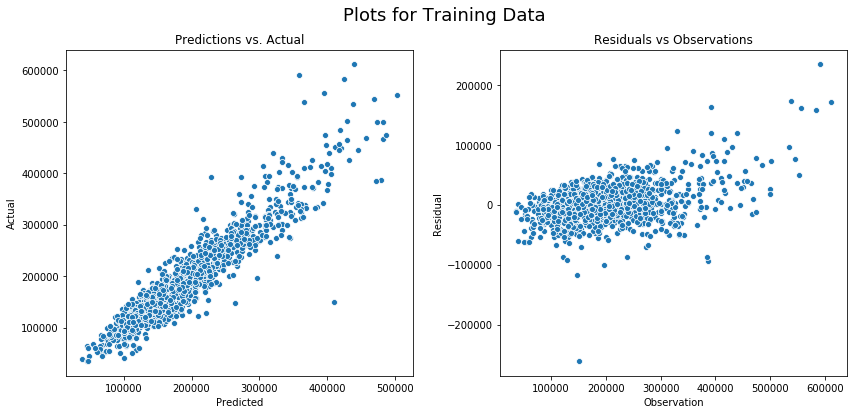

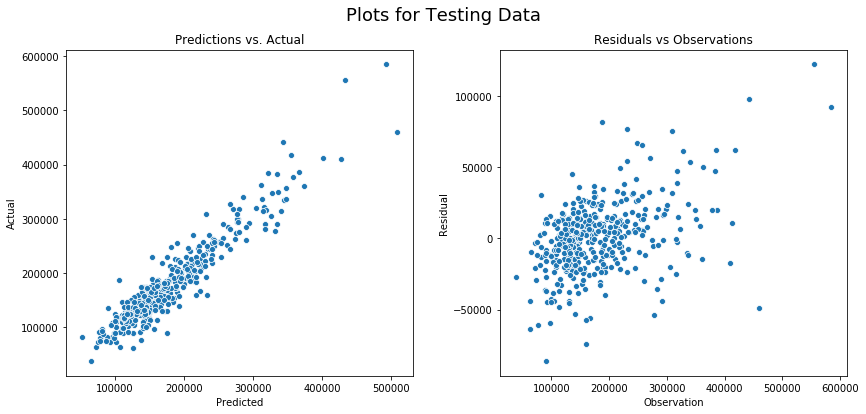

In [80]:
# we'll go through the list 1 by 1
lr, data_w_dum, df_kag = add_dummies_fit_plot('Overall Qual', data_ref)

In [81]:
data_ref = data_w_dum



Garage Cars
The mean of residuals is:  1.4658201303119426e-15
The Mean Absolute Error:  0.10436871632998178
The Sum Squared Error:  34.27010108385123
The Mean Squared Error:  0.020947494550031313
The Root Mean Squared Error:  0.14473249306921826
The Coefficient of Determination:  0.8713539165551522
The Adjusted Coefficient of Determination:  0.8681276824875698
The 10-fold cross validation score:  0.8506966823613492


Train Score: 0.8713539165551522
Test Score: 0.8558762092146518




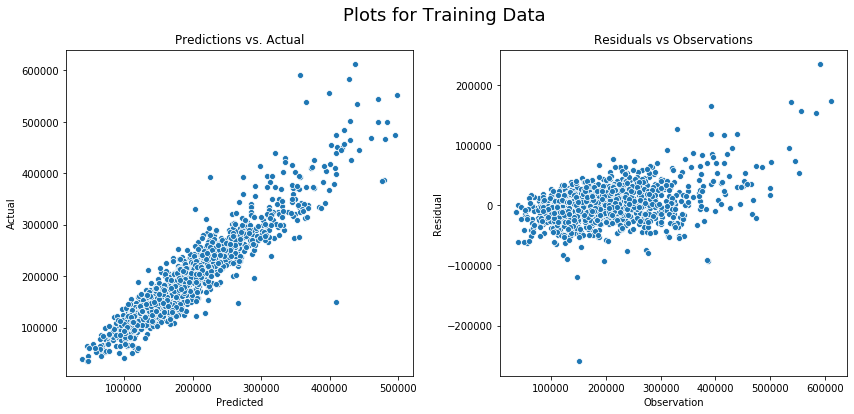

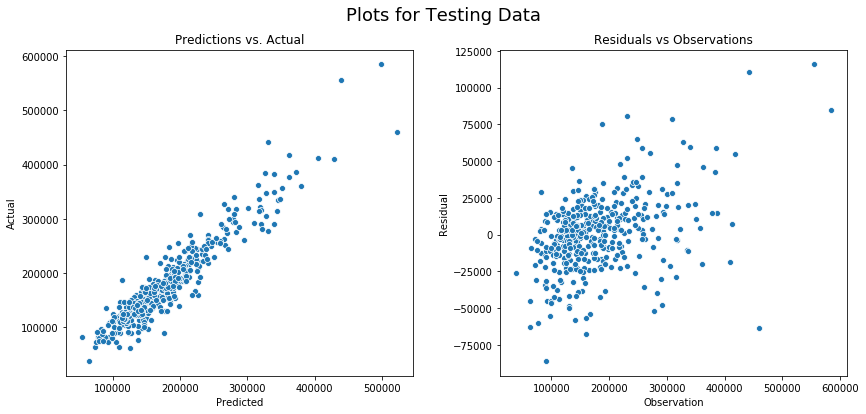

In [82]:
lr, data_w_dum, df_kag = add_dummies_fit_plot('Garage Cars', data_ref)

In [83]:
data_ref = data_w_dum



Year Built
The mean of residuals is:  1.4701633010684224e-15
The Mean Absolute Error:  0.09149936348696777
The Sum Squared Error:  26.63848845222148
The Mean Squared Error:  0.016282694652947117
The Root Mean Squared Error:  0.12760366238061946
The Coefficient of Determination:  0.9000021272220892
The Adjusted Coefficient of Determination:  0.8893798903979132
The 10-fold cross validation score:  0.851775157107906


Train Score: 0.9000021272220892
Test Score: 0.8660159830200655




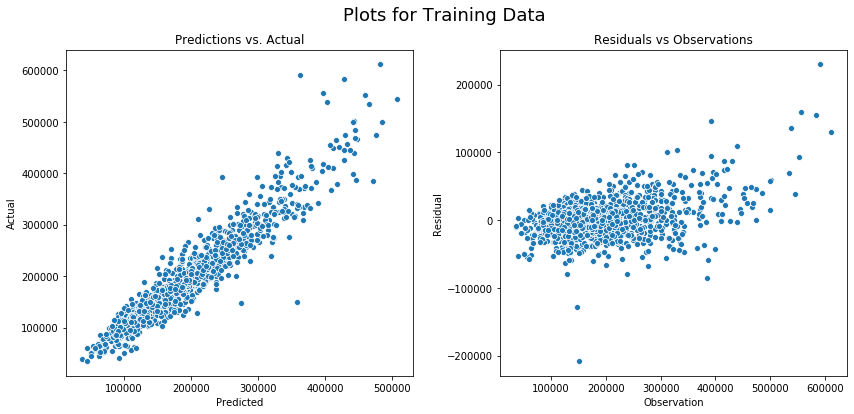

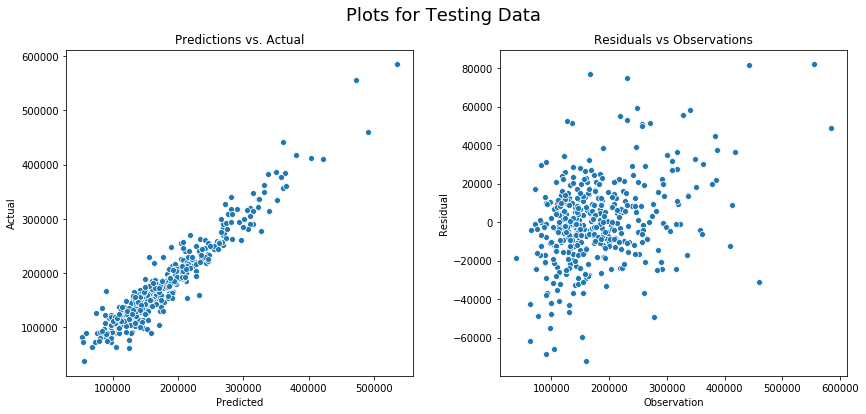

In [84]:
lr, data_w_dum, df_kag = add_dummies_fit_plot('Year Built', data_ref)

In [85]:
# this one is not an improvement, so we won't save it



Full Bath
The mean of residuals is:  9.880713470991613e-17
The Mean Absolute Error:  0.10386209163345214
The Sum Squared Error:  33.891944137217045
The Mean Squared Error:  0.02071634727213756
The Root Mean Squared Error:  0.14393174518547866
The Coefficient of Determination:  0.8727734749624332
The Adjusted Coefficient of Determination:  0.8692549538426011
The 10-fold cross validation score:  0.8520263349149474


Train Score: 0.8727734749624332
Test Score: 0.859102014163699




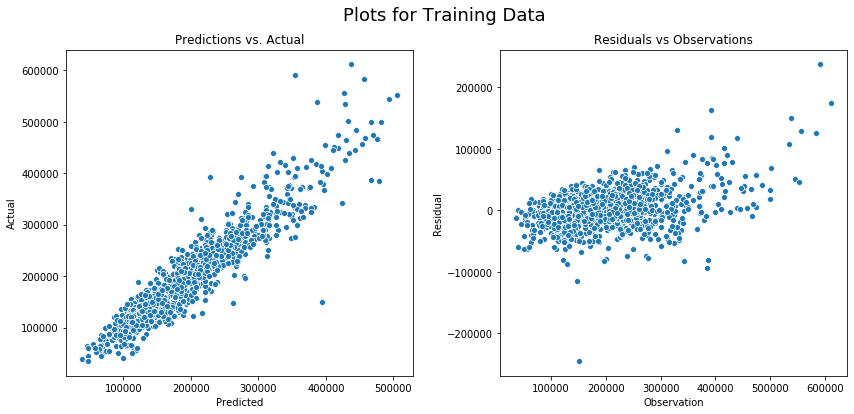

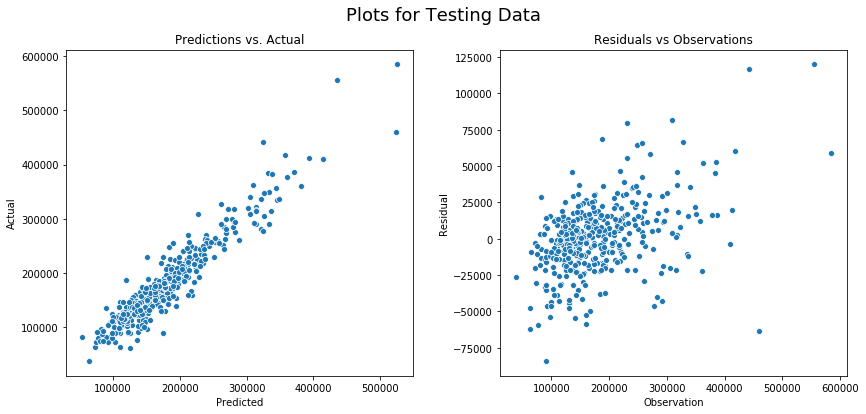

In [86]:
lr, data_w_dum, df_kag = add_dummies_fit_plot('Full Bath', data_ref)

In [87]:
data_ref = data_w_dum



Year Remod/Add
The mean of residuals is:  2.324682147405829e-15
The Mean Absolute Error:  0.0950529443749235
The Sum Squared Error:  28.451146717398935
The Mean Squared Error:  0.01739067647762771
The Root Mean Squared Error:  0.13187371412691654
The Coefficient of Determination:  0.893197613110256
The Adjusted Coefficient of Determination:  0.8859425848695419
The 10-fold cross validation score:  0.8636833756972526


Train Score: 0.893197613110256
Test Score: 0.879919363434513




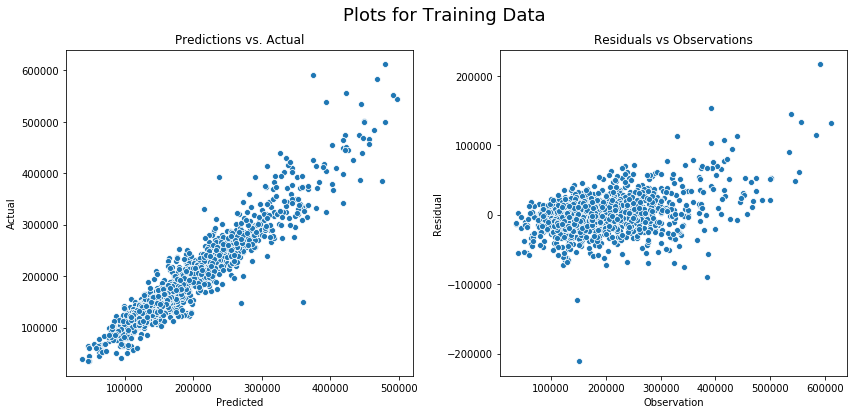

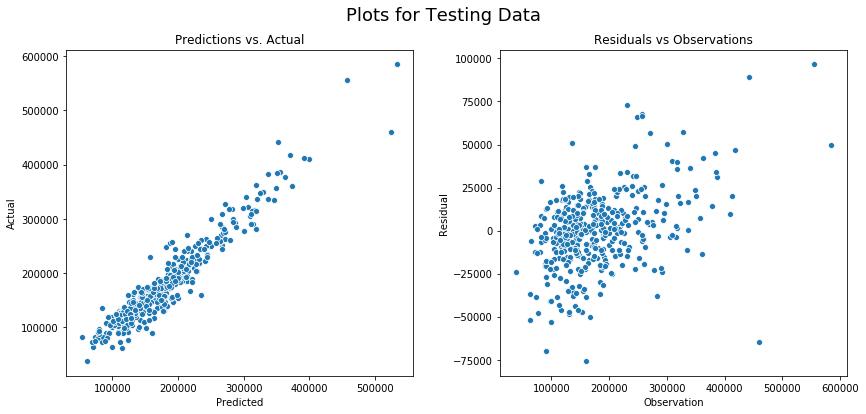

In [88]:
lr, data_w_dum, df_kag = add_dummies_fit_plot('Year Remod/Add', data_ref)

In [89]:
data_ref = data_w_dum


In [90]:
df_kag.head()

,Gr Liv Area,Garage Area,1st Flr SF,BsmtFin SF 1,Open Porch SF,Wood Deck SF,Lot Area,Gr Liv Area^2,Gr Liv Area Garage Area,Gr Liv Area 1st Flr SF,Gr Liv Area Wood Deck SF,Garage Area^2,Garage Area Mas Vnr Area,Garage Area BsmtFin SF 1,Garage Area Open Porch SF,Garage Area Lot Area,1st Flr SF Open Porch SF,1st Flr SF Wood Deck SF,Mas Vnr Area^2,Mas Vnr Area Open Porch SF,Mas Vnr Area Lot Area,BsmtFin SF 1 Wood Deck SF,Open Porch SF^2,Open Porch SF Wood Deck SF,Open Porch SF Lot Area,Wood Deck SF^2,Overall Qual_2,Overall Qual_3,Overall Qual_4,Overall Qual_5,Overall Qual_6,Overall Qual_7,Overall Qual_8,Overall Qual_9,Overall Qual_10,Garage Cars_1.0,Garage Cars_2.0,Garage Cars_3.0,Garage Cars_4.0,Garage Cars_5.0,Full Bath_1,Full Bath_2,Full Bath_3,Full Bath_4,Year Remod/Add_1951,Year Remod/Add_1952,Year Remod/Add_1953,Year Remod/Add_1954,Year Remod/Add_1955,Year Remod/Add_1956,...,Year Remod/Add_1961,Year Remod/Add_1962,Year Remod/Add_1963,Year Remod/Add_1964,Year Remod/Add_1965,Year Remod/Add_1966,Year Remod/Add_1967,Year Remod/Add_1968,Year Remod/Add_1969,Year Remod/Add_1970,Year Remod/Add_1971,Year Remod/Add_1972,Year Remod/Add_1973,Year Remod/Add_1974,Year Remod/Add_1975,Year Remod/Add_1976,Year Remod/Add_1977,Year Remod/Add_1978,Year Remod/Add_1979,Year Remod/Add_1980,Year Remod/Add_1981,Year Remod/Add_1982,Year Remod/Add_1983,Year Remod/Add_1984,Year Remod/Add_1985,Year Remod/Add_1986,Year Remod/Add_1987,Year Remod/Add_1988,Year Remod/Add_1989,Year Remod/Add_1990,Year Remod/Add_1991,Year Remod/Add_1992,Year Remod/Add_1993,Year Remod/Add_1994,Year Remod/Add_1995,Year Remod/Add_1996,Year Remod/Add_1997,Year Remod/Add_1998,Year Remod/Add_1999,Year Remod/Add_2000,Year Remod/Add_2001,Year Remod/Add_2002,Year Remod/Add_2003,Year Remod/Add_2004,Year Remod/Add_2005,Year Remod/Add_2006,Year Remod/Add_2007,Year Remod/Add_2008,Year Remod/Add_2009,Year Remod/Add_2010
2046,1928.0,440.0,908.0,0.0,60.0,0.0,9142.0,3717184.0,848320.0,1750624.0,0.0,193600.0,0.0,0.0,26400.0,4022480.0,54480.0,0.0,0.0,0.0,0.0,0.0,3600.0,0.0,548520.0,0.0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2047,1967.0,580.0,1967.0,0.0,0.0,170.0,9662.0,3869089.0,1140860.0,3869089.0,334390.0,336400.0,0.0,0.0,0.0,5603960.0,0.0,334390.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,28900.0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2048,1496.0,426.0,664.0,554.0,24.0,100.0,17104.0,2238016.0,637296.0,993344.0,149600.0,181476.0,0.0,236004.0,10224.0,7286304.0,15936.0,66400.0,0.0,0.0,0.0,55400.0,576.0,2400.0,410496.0,10000.0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
2049,968.0,480.0,968.0,0.0,0.0,0.0,8520.0,937024.0,464640.0,937024.0,0.0,230400.0,0.0,0.0,0.0,4089600.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
2050,1394.0,514.0,1394.0,609.0,76.0,0.0,9500.0,1943236.0,716516.0,1943236.0,0.0,264196.0,126958.0,313026.0,39064.0,4883000.0,105944.0,0.0,61009.0,18772.0,2346500.0,0.0,5776.0,0.0,722000.0,0.0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [91]:
# I think that is about as good as it is going to get. Lets submit
kag_counter = 8
kag_counter = create_kaggle_csv(lr, df_kag, kag_counter)

This is submission number:  8




Foundation
The mean of residuals is:  1.509251837876741e-16
The Mean Absolute Error:  0.09223507683486658
The Sum Squared Error:  27.348021635753035
The Mean Squared Error:  0.016716394642880827
The Root Mean Squared Error:  0.12929189705035976
The Coefficient of Determination:  0.8973386199008778
The Adjusted Coefficient of Determination:  0.890005664179512
The 10-fold cross validation score:  0.864998481645728


Train Score: 0.8973386199008778
Test Score: 0.8851468446896761




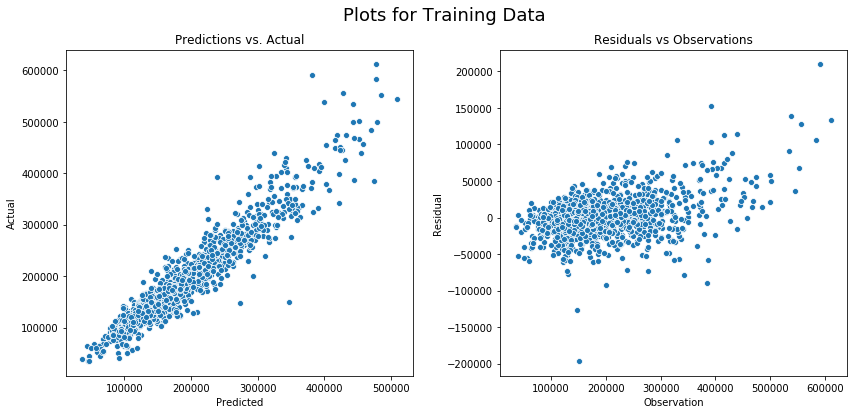

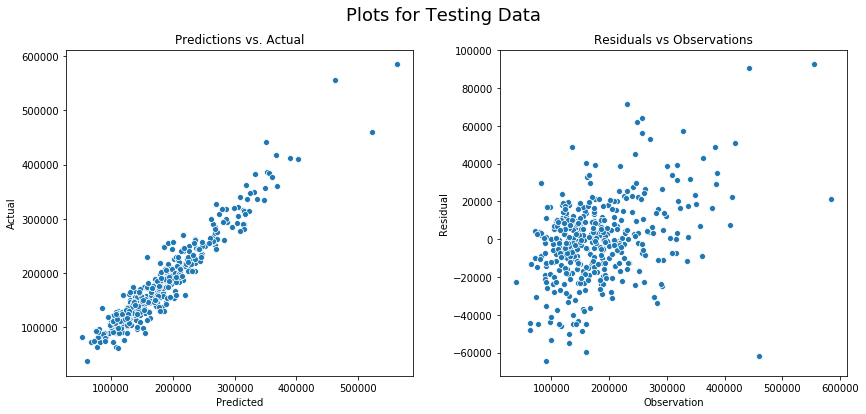

In [92]:
lr, data_w_dum, df_kag = add_dummies_fit_plot('Foundation', data_ref)

In [93]:
data_ref = data_w_dum



Fireplaces
The mean of residuals is:  1.8002442785608896e-15
The Mean Absolute Error:  0.09083129119786132
The Sum Squared Error:  26.50062159210365
The Mean Squared Error:  0.016198423956053577
The Root Mean Squared Error:  0.1272730291776446
The Coefficient of Determination:  0.9005196638219258
The Adjusted Coefficient of Determination:  0.8931338044341977
The 10-fold cross validation score:  0.8693973519123105


Train Score: 0.9005196638219258
Test Score: 0.8914168274721576




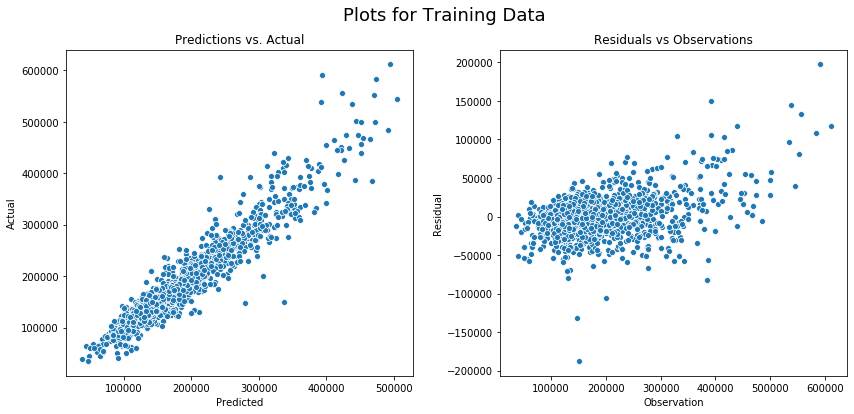

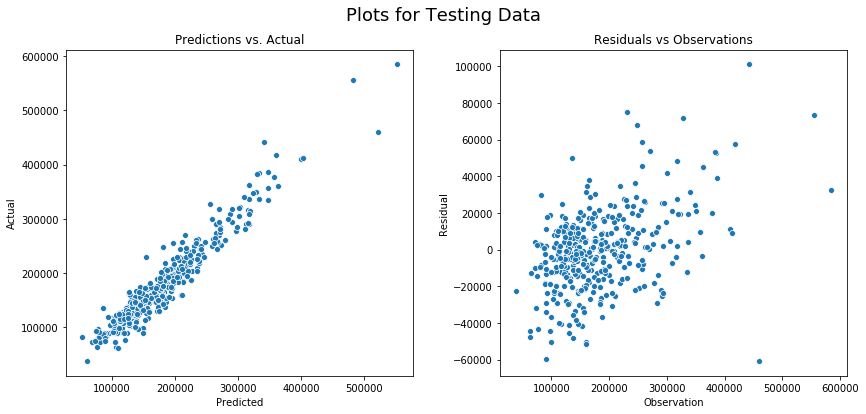

In [94]:
lr, data_w_dum, df_kag = add_dummies_fit_plot('Fireplaces', data_ref)

In [95]:
data_ref = data_w_dum



Bsmt Full Bath
The mean of residuals is:  5.591832348967781e-16
The Mean Absolute Error:  0.09063433165621362
The Sum Squared Error:  26.38537281386907
The Mean Squared Error:  0.016127978492585005
The Root Mean Squared Error:  0.12699597825358488
The Coefficient of Determination:  0.9009522947005277
The Adjusted Coefficient of Determination:  0.8933884146381585
The 10-fold cross validation score:  0.8695096419774695


Train Score: 0.9009522947005277
Test Score: 0.8911111132400579




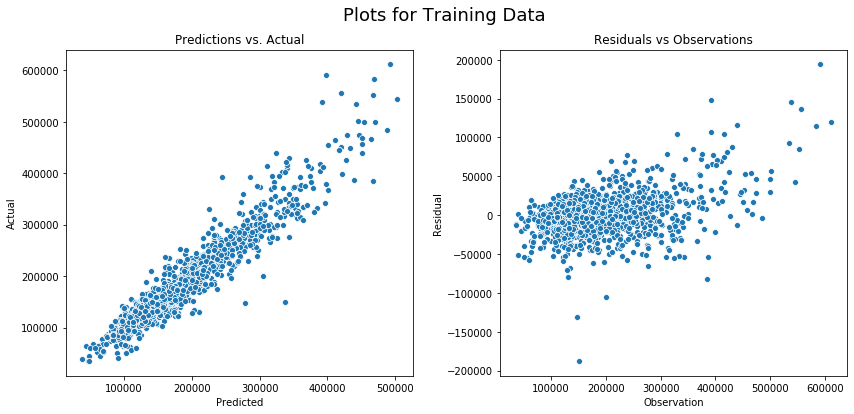

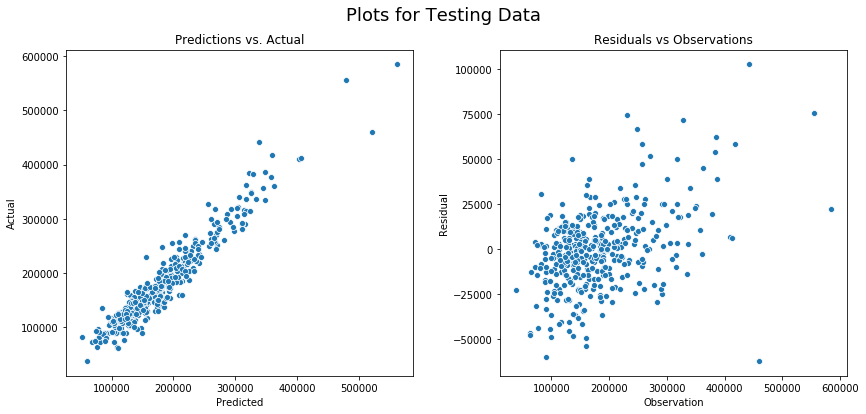

In [96]:
lr, data_w_dum, df_kag = add_dummies_fit_plot('Bsmt Full Bath', data_ref)

In [97]:
data_ref = data_w_dum



Heating QC
The mean of residuals is:  1.0521331157572389e-15
The Mean Absolute Error:  0.08959302033617723
The Sum Squared Error:  25.748241224217466
The Mean Squared Error:  0.015738533755634148
The Root Mean Squared Error:  0.12545331305164542
The Coefficient of Determination:  0.9033440146270935
The Adjusted Coefficient of Determination:  0.8956880949935959
The 10-fold cross validation score:  0.8714522518618482


Train Score: 0.9033440146270935
Test Score: 0.8942517637594242




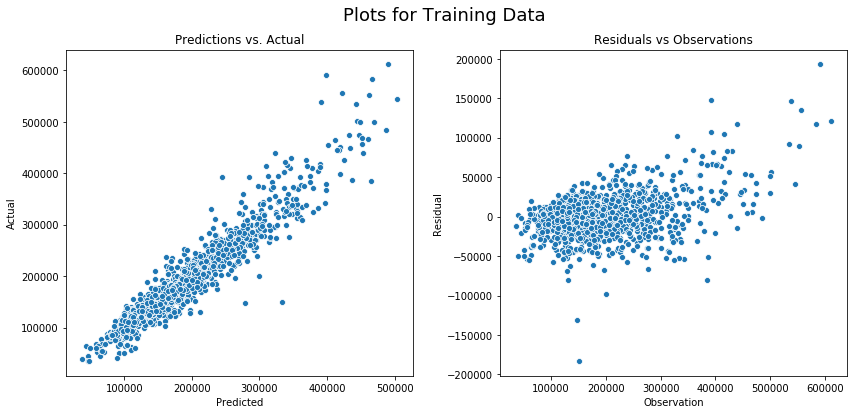

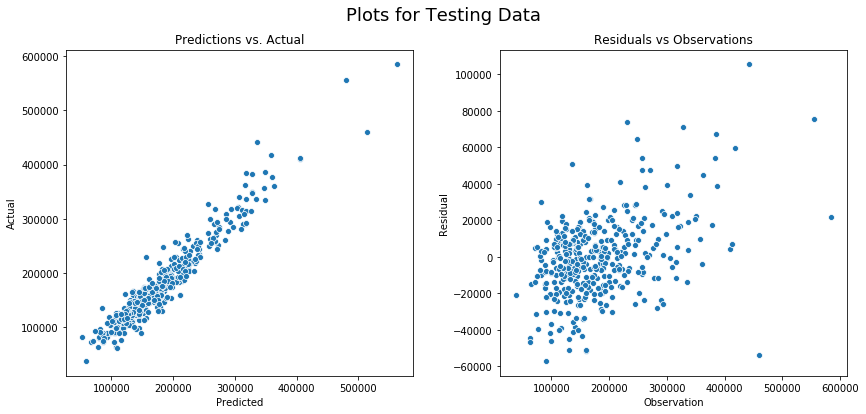

In [98]:
lr, data_w_dum, df_kag = add_dummies_fit_plot('Heating QC', data_ref)

In [99]:
data_ref = data_w_dum



Exter Qual
The mean of residuals is:  6.579903696066943e-16
The Mean Absolute Error:  0.08897067783643732
The Sum Squared Error:  25.24728920043497
The Mean Squared Error:  0.015432328362124065
The Root Mean Squared Error:  0.12422692285541032
The Coefficient of Determination:  0.9052245318655955
The Adjusted Coefficient of Determination:  0.8975146227514872
The 10-fold cross validation score:  0.8723153936106878


Train Score: 0.9052245318655955
Test Score: 0.8939046739460955




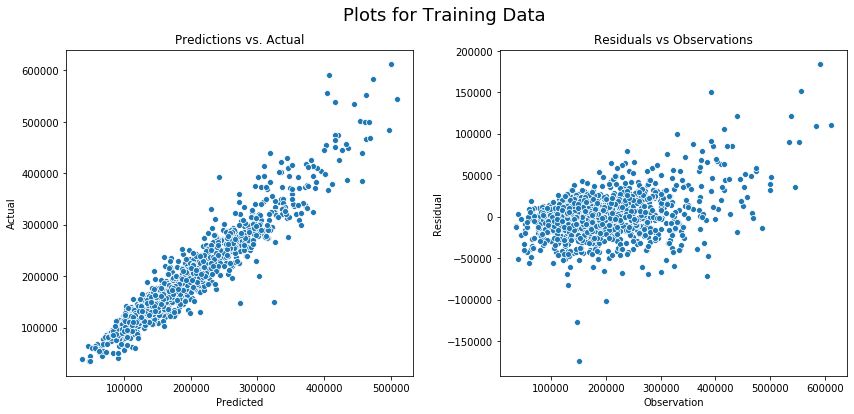

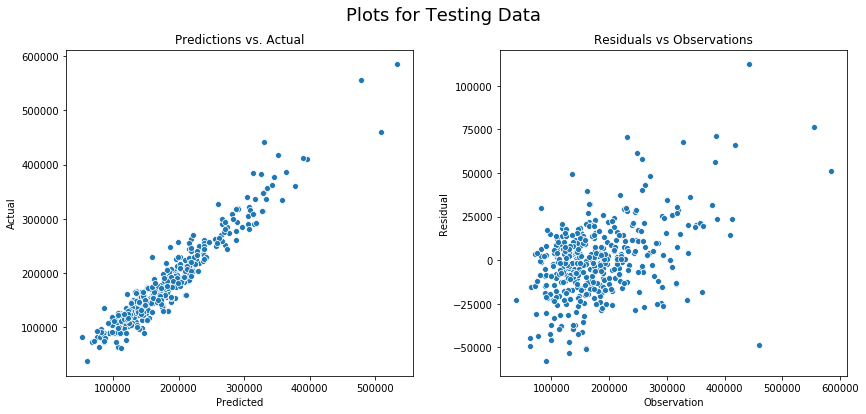

In [100]:
lr, data_w_dum, df_kag = add_dummies_fit_plot('Exter Qual', data_ref)

In [101]:
data_ref = data_w_dum



Bsmt Exposure
The mean of residuals is:  9.630981152494023e-16
The Mean Absolute Error:  0.08832679867220779
The Sum Squared Error:  24.985875195950165
The Mean Squared Error:  0.015272539850825283
The Root Mean Squared Error:  0.1235821178440687
The Coefficient of Determination:  0.9062058504719317
The Adjusted Coefficient of Determination:  0.8983741322210791
The 10-fold cross validation score:  0.8732948428089354


Train Score: 0.9062058504719317
Test Score: 0.8941635181783226




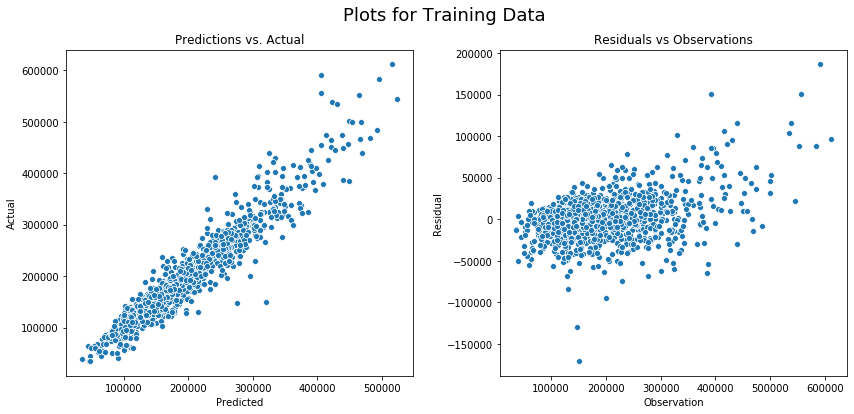

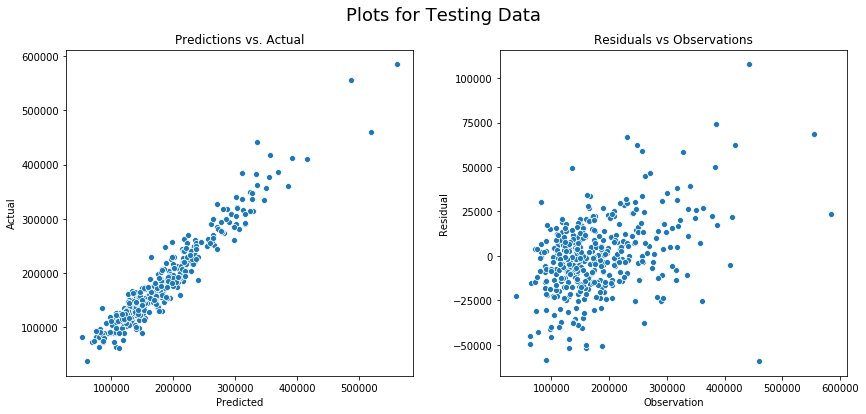

In [102]:
lr, data_w_dum, df_kag = add_dummies_fit_plot('Bsmt Exposure', data_ref)

In [103]:
data_ref = data_w_dum



Central Air
The mean of residuals is:  1.1672271408039543e-15
The Mean Absolute Error:  0.08777530955875307
The Sum Squared Error:  24.69945068256602
The Mean Squared Error:  0.015097463742399769
The Root Mean Squared Error:  0.12287173695524846
The Coefficient of Determination:  0.9072810556999322
The Adjusted Coefficient of Determination:  0.8994724973934942
The 10-fold cross validation score:  0.8747240890493915


Train Score: 0.9072810556999322
Test Score: 0.8970986234570301




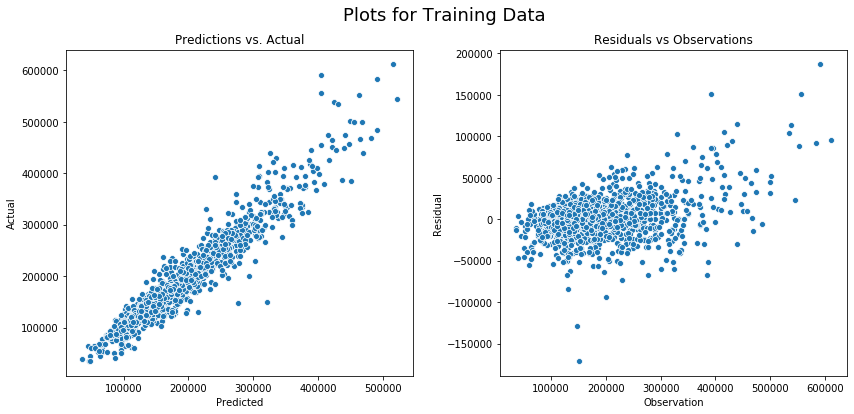

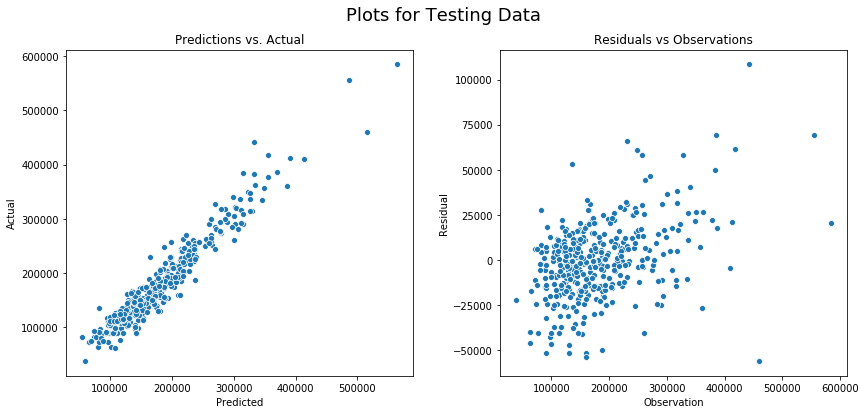

In [104]:
lr, data_w_dum, df_kag = add_dummies_fit_plot('Central Air', data_ref)

In [105]:
data_ref = data_w_dum



Functional
The mean of residuals is:  1.2052298849231528e-15
The Mean Absolute Error:  0.0844787305942882
The Sum Squared Error:  22.677413485835416
The Mean Squared Error:  0.01386149968571847
The Root Mean Squared Error:  0.11773487030492907
The Coefficient of Determination:  0.9148715546395975
The Adjusted Coefficient of Determination:  0.9072718133482625
The 10-fold cross validation score:  0.8821258470073298


Train Score: 0.9148715546395975
Test Score: 0.8966173015388661




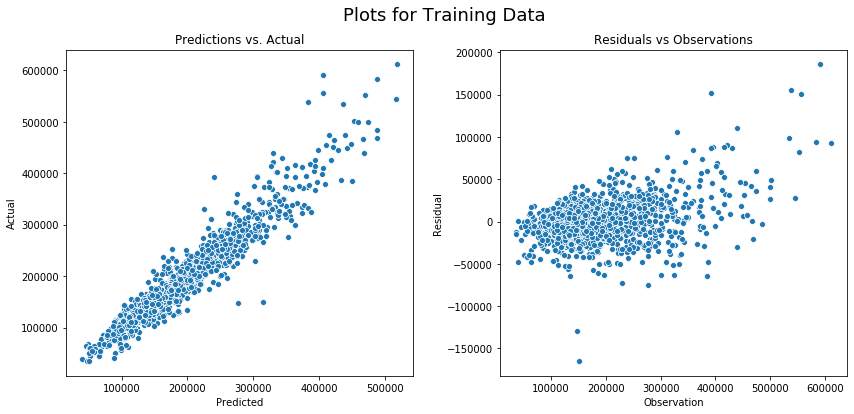

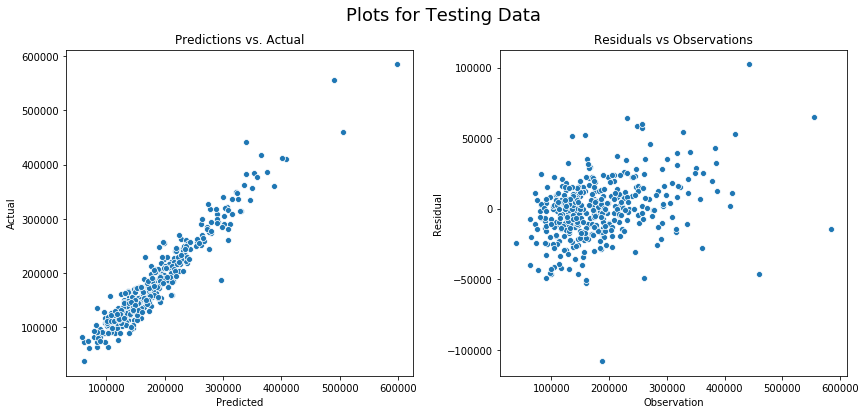

In [106]:
lr, data_w_dum, df_kag = add_dummies_fit_plot('Functional', data_ref)

In [107]:
data_ref = data_w_dum



Heating
The mean of residuals is:  1.586343118804258e-15
The Mean Absolute Error:  0.08401028757729381
The Sum Squared Error:  22.47392810702742
The Mean Squared Error:  0.01373711986982116
The Root Mean Squared Error:  0.11720546006829699
The Coefficient of Determination:  0.915635415736998
The Adjusted Coefficient of Determination:  0.9077967277606896
The 10-fold cross validation score:  0.8825811640846755


Train Score: 0.915635415736998
Test Score: 0.9005418261852144




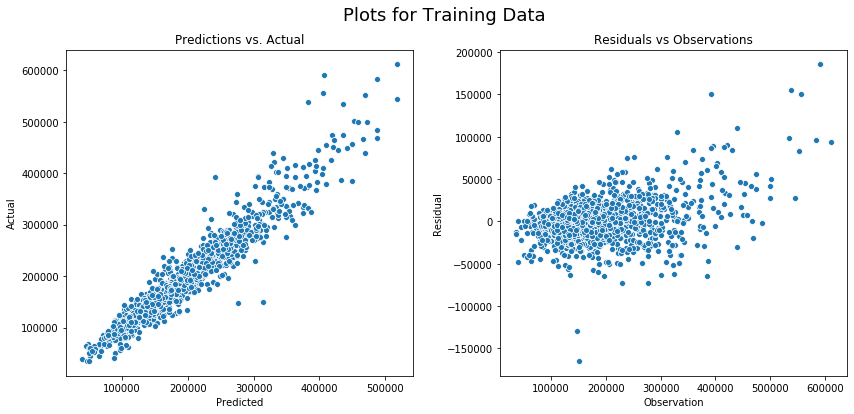

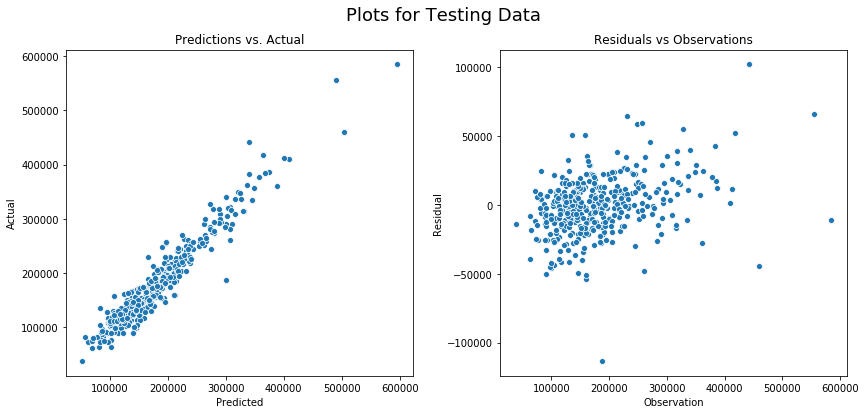

In [108]:
lr, data_w_dum, df_kag = add_dummies_fit_plot('Heating', data_ref)

In [109]:
data_ref = data_w_dum



Garage Finish
The mean of residuals is:  9.728702494514819e-16
The Mean Absolute Error:  0.08396870247909656
The Sum Squared Error:  22.450247014544928
The Mean Squared Error:  0.013722644874416216
The Root Mean Squared Error:  0.11714369327631861
The Coefficient of Determination:  0.9157243118797936
The Adjusted Coefficient of Determination:  0.9077705822780874
The 10-fold cross validation score:  0.8823269507519498


Train Score: 0.9157243118797936
Test Score: 0.9006291289256076




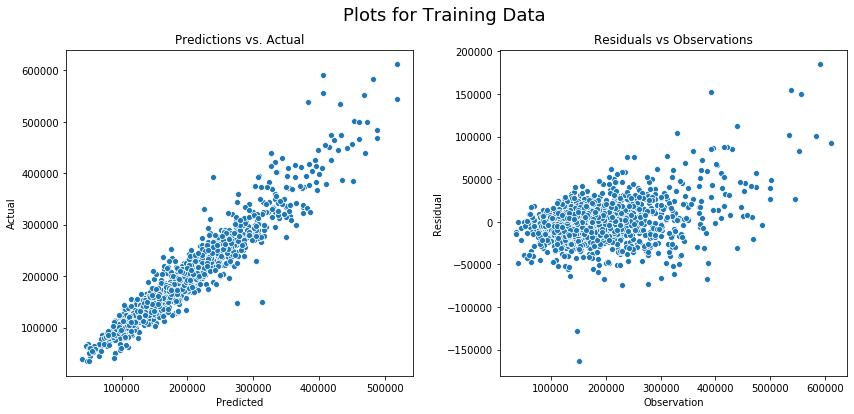

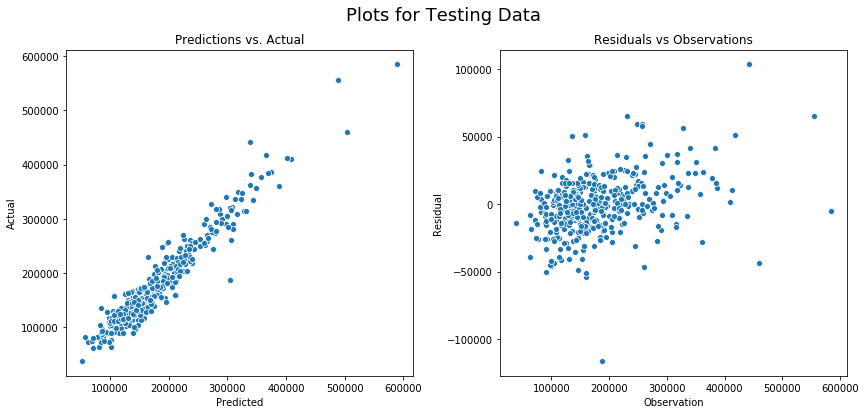

In [110]:
lr, data_w_dum, df_kag = add_dummies_fit_plot('Garage Finish', data_ref)

In [111]:
data_ref = data_w_dum



Neighborhood
The mean of residuals is:  1.6764639120012144e-15
The Mean Absolute Error:  0.07912036812708718
The Sum Squared Error:  19.76928947725592
The Mean Squared Error:  0.012083917773383815
The Root Mean Squared Error:  0.1099268746639502
The Coefficient of Determination:  0.9257883232525729
The Adjusted Coefficient of Determination:  0.9172896445248512
The 10-fold cross validation score:  0.8868160394483391


Train Score: 0.9257883232525729
Test Score: 0.9006212544577082




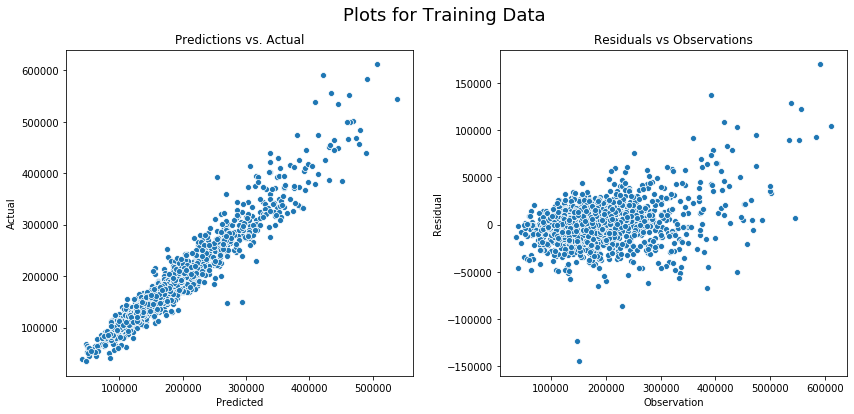

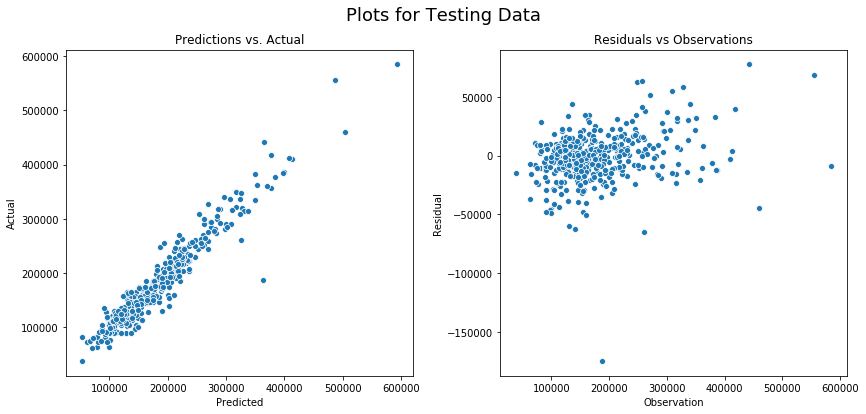

In [112]:
lr, data_w_dum, df_kag = add_dummies_fit_plot('Neighborhood', data_ref)

In [113]:
data_ref = data_w_dum



Garage Type
The mean of residuals is:  4.419176244718227e-16
The Mean Absolute Error:  0.07843699281414
The Sum Squared Error:  19.494415123244533
The Mean Squared Error:  0.011915901664574898
The Root Mean Squared Error:  0.1091599819740499
The Coefficient of Determination:  0.9268201704886367
The Adjusted Coefficient of Determination:  0.9181607241784686
The 10-fold cross validation score:  0.8890300535810557


Train Score: 0.9268201704886367
Test Score: 0.9007436294812021




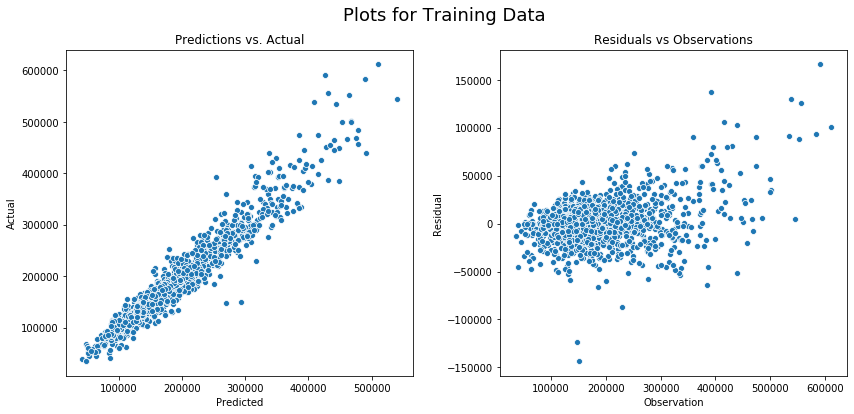

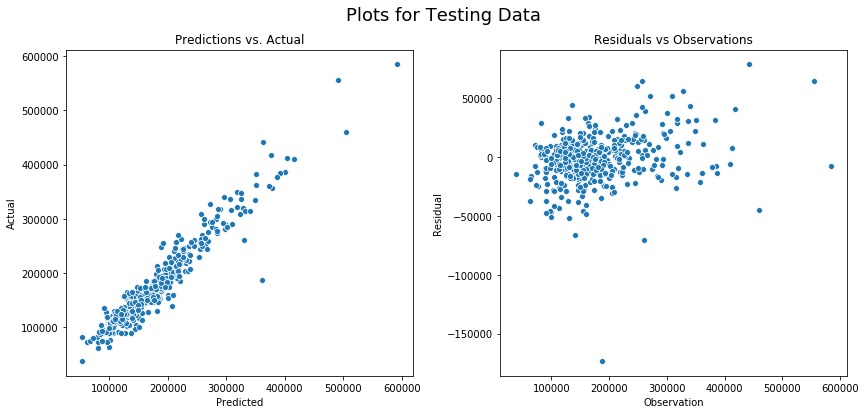

In [114]:
lr, data_w_dum, df_kag = add_dummies_fit_plot('Garage Type', data_ref)

In [115]:
data_ref = data_w_dum

In [116]:
kag_counter = create_kaggle_csv(lr, df_kag, kag_counter)

This is submission number:  9




MS SubClass
The mean of residuals is:  1.9544268404159236e-17
The Mean Absolute Error:  0.07563137150647706
The Sum Squared Error:  18.570204974475025
The Mean Squared Error:  0.011350981035742681
The Root Mean Squared Error:  0.1065409828927004
The Coefficient of Determination:  0.9302895508569136
The Adjusted Coefficient of Determination:  0.9212324918113709
The 10-fold cross validation score:  0.8920157257927999


Train Score: 0.9302895508569136
Test Score: 0.9024165503290081




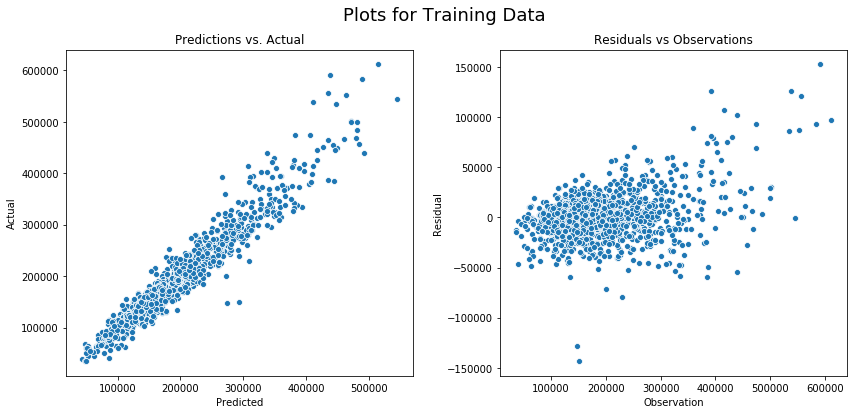

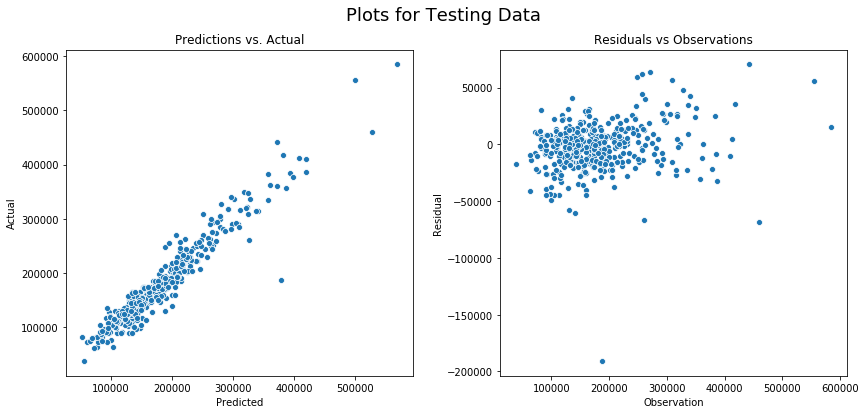

In [117]:
lr, data_w_dum, df_kag = add_dummies_fit_plot('MS SubClass', data_ref)

In [118]:
data_ref = data_w_dum



Kitchen Qual
The mean of residuals is:  5.722127471662176e-16
The Mean Absolute Error:  0.0746859081557162
The Sum Squared Error:  18.122780830822574
The Mean Squared Error:  0.011077494395368322
The Root Mean Squared Error:  0.10524967646206007
The Coefficient of Determination:  0.9319691304875285
The Adjusted Coefficient of Determination:  0.9229172060617526
The 10-fold cross validation score:  0.8962974779275031


Train Score: 0.9319691304875285
Test Score: 0.9012396948416037




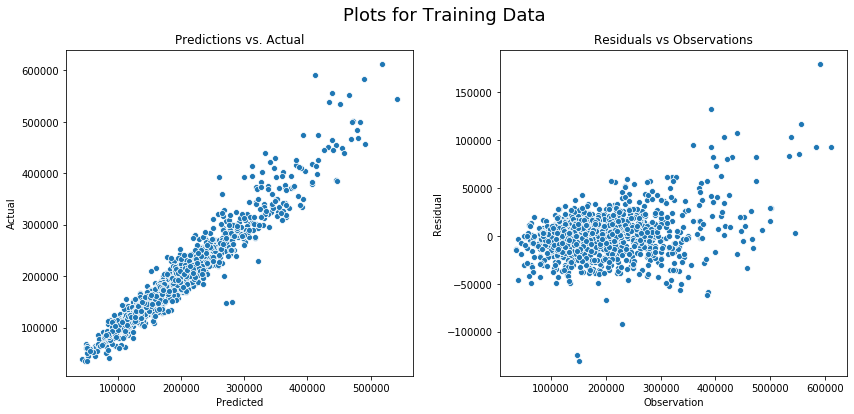

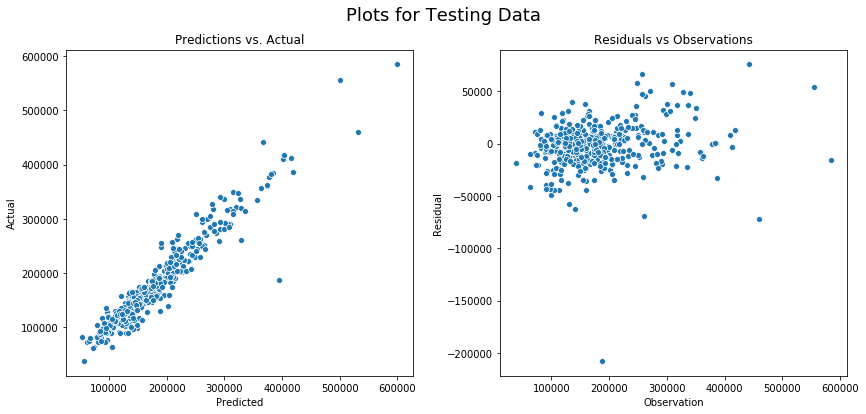

In [119]:
lr, data_w_dum, df_kag = add_dummies_fit_plot('Kitchen Qual', data_ref)

In [120]:
data_ref = data_w_dum



Misc Feature
The mean of residuals is:  9.19666407684604e-16
The Mean Absolute Error:  0.07454860884165172
The Sum Squared Error:  18.079906297566062
The Mean Squared Error:  0.011051287467949915
The Root Mean Squared Error:  0.10512510389031687
The Coefficient of Determination:  0.9321300766361693
The Adjusted Coefficient of Determination:  0.9228858063239311
The 10-fold cross validation score:  0.896445088681935


Train Score: 0.9321300766361693
Test Score: 0.9007645909365222




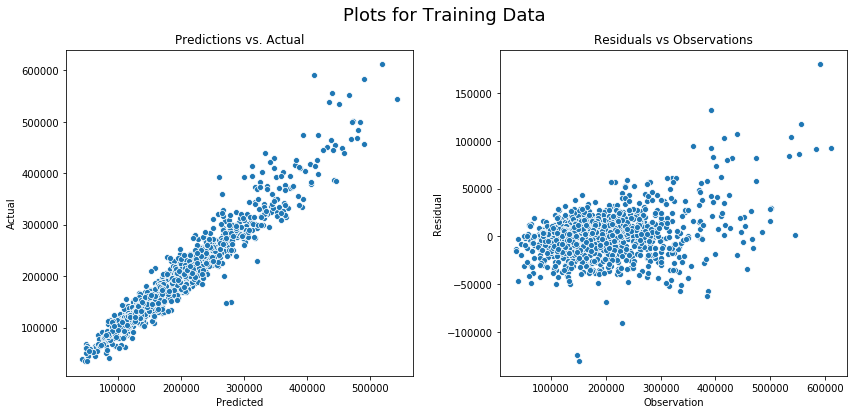

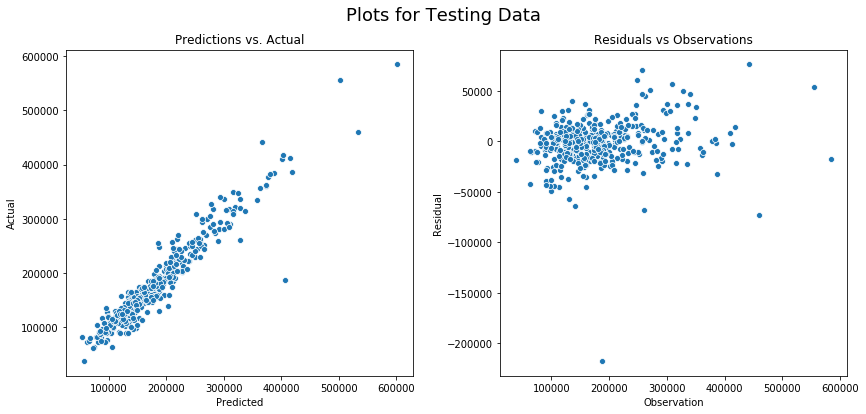

In [121]:
lr, data_w_dum, df_kag = add_dummies_fit_plot('Misc Feature', data_ref)

In [122]:
data_ref = data_w_dum



Fireplace Qu
The mean of residuals is:  1.1379107381977154e-15
The Mean Absolute Error:  0.07451946728666484
The Sum Squared Error:  18.03040359632753
The Mean Squared Error:  0.011021029093109739
The Root Mean Squared Error:  0.10498108921662862
The Coefficient of Determination:  0.9323159041777542
The Adjusted Coefficient of Determination:  0.9228825807182077
The 10-fold cross validation score:  0.8962986153698834


Train Score: 0.9323159041777542
Test Score: 0.9006798507941528




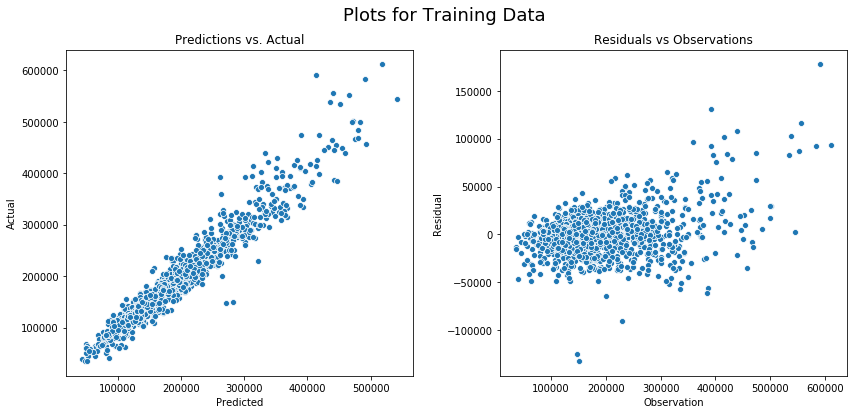

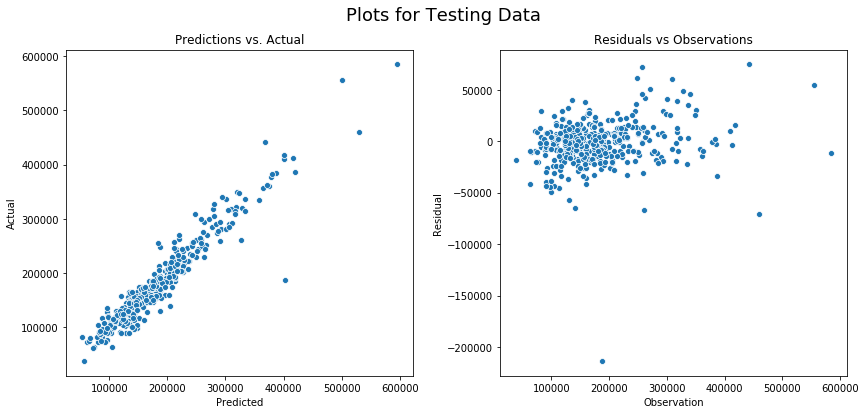

In [123]:
lr, data_w_dum, df_kag = add_dummies_fit_plot('Fireplace Qu', data_ref)

## Final Conclusions:

We've managed to get the 